In [1]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import pickle
from omegaconf import DictConfig, OmegaConf

In [2]:
# 将 MScProject 目录添加到 Python 模块搜索路径
sys.path.append(os.path.abspath('..'))
# 从 DataGenerate.py 导入 DataGenerate 类 用于pickle导入
from DataGenerate import TrainValidManage


In [3]:
# 加载 config.yaml 文件
config = OmegaConf.load("../config/config.yaml")

# 打印完整的配置内容
print(OmegaConf.to_yaml(config))

base:
  'N': 10
  T: 11000
  T_train_val: 10000
  train_ratio: 0.8
  T_train: 8000
  T_val: 2000
  T_test: 1000
data_generation:
  load_data:
    node_mean: 50.0
    node_var: 10.0
    node_iid_var: 5.0
    node_theta: 0.9
  latency:
    mean: 0.0
    var: 0.0
    iid_var: 0.0
    theta: 0.0
exp4:
  batch_size: 64
  seq_length: 20
  input_size: 10
  output_size: 10
  learning_rate: 0.001
  num_epochs: 100
  num_workers: 24
  device: cuda
  mix_precision: true
  patience_epochs: 6
  min_delta: 0.001
  mode: min
  factor: 0.1
  patience_lr: 2
  min_lr: 1.0e-06
  threshold: 0.01
  ARconfig:
    order: 5
  LSTMCconfig:
    hidden_size: 128
    num_layers: 4
  GNNconfig:
    hidden_size: 128
    num_layers: 4



In [4]:
# # 明确添加安全的全局对象, 用于防止导入pickle时的警告信息
# torch.serialization.add_safe_globals({"TrainValidManage": TrainValidManage})

# 从文件加载对象
with open('../Data/ar1_data_train_val_manage.pkl', 'rb') as f:
    ar1_data_train_val_manage = pickle.load(f)
    
# 从文件加载对象
with open('../Data/iid_data_train_val_manage.pkl', 'rb') as f:
    iid_data_train_val_manage = pickle.load(f)

/usr/local/Anaconda3/envs/MScProject/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


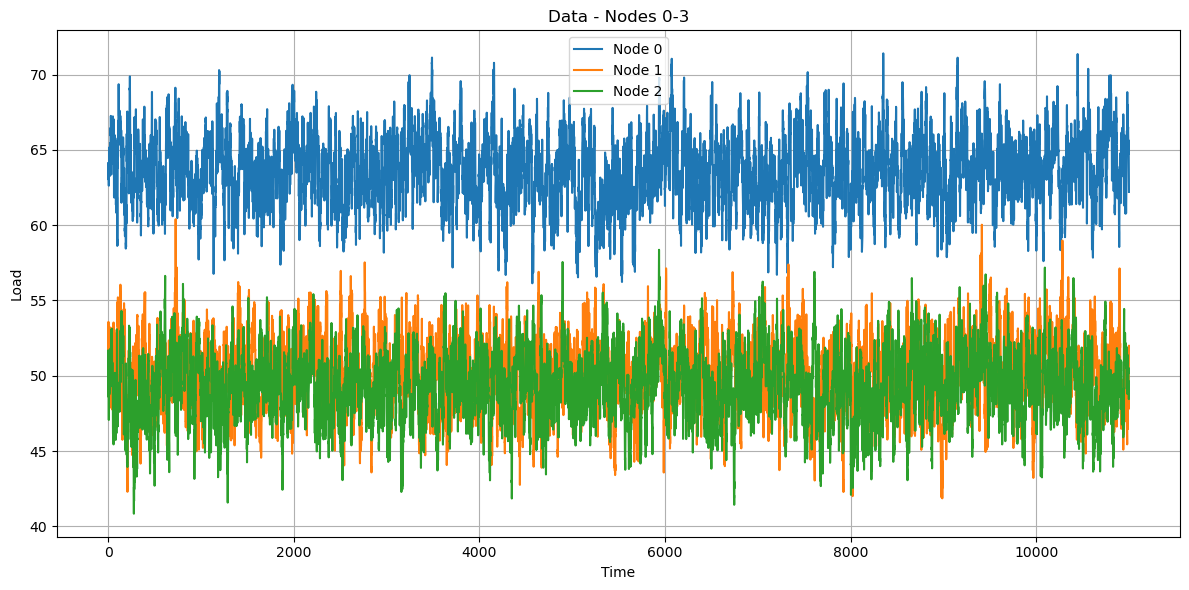

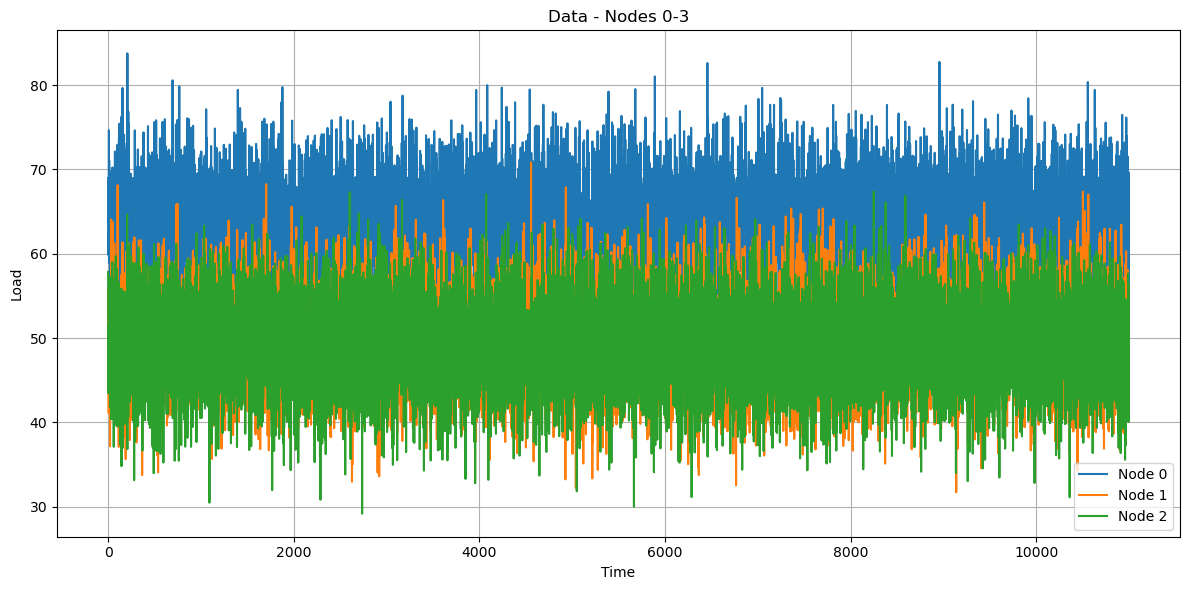

In [5]:
ar1_data_train_val_manage.plot_range_data(ar1_data_train_val_manage.data_np[:3, :], title='Data')
iid_data_train_val_manage.plot_range_data(iid_data_train_val_manage.data_np[:3, :], title='Data')

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.optim.lr_scheduler as lr_scheduler


In [7]:
# class ModelExpert:
#     def __init__(self, config, data_manage):
#         self.config = config
#         self.data_manage = data_manage
# 
#         self.device = self.config.device
#         self.mix_precision = self.config.mix_precision
# 
#         self.N = self.config.N
#         self.T = self.config.T
#         self.T_train_val = self.config.T_train_val
#         self.train_ratio = self.config.train_ratio
#         self.T_train = self.config.T_train
#         self.T_val = self.config.T_val
#         self.T_test = self.config.T_test
# 
#         self.train_val_data_np = self.data_manage.train_val_data_np
#         self.train_data_np = self.data_manage.train_data_np
#         self.val_data_np = self.data_manage.val_data_np
#         self.test_data_np = self.data_manage.test_data_np
# 
#         self.train_val_data_tensor = self.data_manage.train_val_data_tensor
#         self.train_data_tensor = self.data_manage.train_data_tensor
#         self.val_data_tensor = self.data_manage.val_data_tensor
#         self.test_data_tensor = self.data_manage.test_data_tensor
# 
#         self.train_val_dataloader = self.data_manage.train_val_dataloader
#         self.train_dataloader = self.data_manage.train_dataloader
#         self.val_dataloader = self.data_manage.val_dataloader
# 
#         self.edge_index = self.data_manage.edge_index_tensor
# 
#         self.num_epochs = self.config.num_epochs
#         self.seq_length = self.config.seq_length
#         self.output_size = self.config.output_size
#         self.patience_epochs = self.config.patience_epochs
#         self.min_delta = self.config.min_delta
# 
#         self.model = self.LSTMModel(
#             input_size=self.config.input_size,
#             hidden_size=self.config.lstm_config.hidden_size,
#             output_size=self.config.output_size,
#             num_layers=self.config.lstm_config.num_layers
#         ).to(self.device)
# 
#         self.criterion = nn.MSELoss()
#         self.optimizer = optim.Adam(self.model.parameters(), lr=self.config.learning_rate)
# 
#         # 初始化调度器
#         self.scheduler = lr_scheduler.ReduceLROnPlateau(
#             self.optimizer,
#             mode=self.config.mode,  # 'min' 表示监控的指标需要最小化
#             factor=self.config.factor,  # 每次减少学习率的比例
#             patience=self.config.patience_lr,  # 当监控的指标在 patience 个 epoch 内没有改善时减少学习率
#             min_lr=self.config.min_lr,  # 学习率的下限
#             threshold=config.threshold  # 用于衡量监控指标的阈值，小于该值表示改善不明显
#         )
# 
#         # 用于记录预测值
#         self.train_predictions = torch.zeros((self.T_test, self.output_size), device=self.device)
#         self.val_predictions = torch.zeros((self.T_test, self.output_size), device=self.device)
#         self.test_predictions = torch.zeros((self.T_test, self.output_size), device=self.device)
# 
#         # 用于记录损失的列表
#         self.train_val_losses = []
#         self.train_losses = []
#         self.val_losses = []
#         self.fine_tune_losses = []
# 
#         # 用于记录学习率的列表
#         self.train_val_learning_rates = []
#         self.train_with_val_learning_rates = []
#         self.fine_tune_learning_rates = []
# 
#         self.epochs_trained = 0  # 用于记录实际训练的 epoch 数
# 
# 
#     class LSTMModel(nn.Module):
#         def __init__(self, input_size, hidden_size, output_size, num_layers):
#             super().__init__()
#             self.hidden_size = hidden_size
#             self.num_layers = num_layers
#             self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#             self.layer_norm = nn.LayerNorm(hidden_size)
#             self.fc = nn.Linear(hidden_size, output_size)
# 
#         def forward(self, x):
#             h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#             c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#             out, _ = self.lstm(x, (h_0, c_0))
#             out = self.layer_norm(out[:, -1, :])
#             out = F.relu(out)
#             out = self.fc(out)
#             return out
# 
#     # 定义早停机制类
#     class EarlyStopping:
#         def __init__(self, patience_epochs=5, min_delta=1e-2):
#             # patience: 当验证集损失连续 patience 次没有下降时，停止训练
#             # min_delta: 最小的损失下降值，小于该值则不认为损失下降
# 
#             self.patience_epochs = patience_epochs
#             self.min_delta = min_delta
#             self.counter = 0
#             self.best_loss = None
#             self.early_stop = False
# 
#         def __call__(self, train_loss):
#             if self.best_loss is None:
#                 self.best_loss = train_loss
#             elif train_loss < self.best_loss - self.min_delta:
#                 self.best_loss = train_loss
#                 self.counter = 0
#             else:
#                 self.counter += 1
#                 if self.counter >= self.patience_epochs:
#                     self.early_stop = True
# 
#     def train_with_val(self):
#         scaler = torch.amp.GradScaler(device=self.device) if self.mix_precision else None
#         early_stopping = self.EarlyStopping(patience_epochs=self.patience_epochs, min_delta=self.min_delta)
# 
#         print(f'device: {torch.cuda.get_device_name() if self.device == "cuda" else "CPU"}')
# 
#         self.model.train()
#         for epoch in tqdm(range(self.num_epochs), desc="Training"):
#             train_cumulative_loss = 0.0  # 训练集累积损失
#             val_cumulative_loss = 0.0  # 验证集累积损失
# 
#             epoch_train_pred = torch.zeros((self.T_train, self.output_size), device=self.device)
#             epoch_val_pred = torch.zeros((self.T_val, self.output_size), device=self.device)
# 
#             # 累积的起始位置
#             train_start_idx = 0
#             val_start_idx = 0
# 
#             # 训练阶段
#             self.model.train()  # 确保模型处于训练模式
#             for train, val in self.train_dataloader:
#                 batch_size = train.size(0)
#                 end_idx = train_start_idx + batch_size
# 
#                 train, val = train.to(self.device, non_blocking=True).float(), val.to(self.device, non_blocking=True).float()
# 
#                 self.optimizer.zero_grad()  # 梯度清零
# 
#                 if self.mix_precision:  # 混合精度训练
#                     with torch.amp.autocast(device_type=self.device):
#                         if self.type == 'LSTM':
#                             train_pred = self.model(train)  # 前向传播, shape: [batch_size, output_size], [64, 10]
#                         elif self.type == 'GNN':
#                             train_pred = self.model(train)  # TODO
#                         train_loss = self.criterion(train_pred, val)
# 
#                     scaler.scale(train_loss).backward()
#                     scaler.step(self.optimizer)
#                     scaler.update()
# 
#                 else:
#                     if self.type == 'LSTM':
#                         train_pred = self.model(train)  # 前向传播
#                     elif self.type == 'GNN':
#                         train_pred = self.model(train)
#                     train_loss = self.criterion(train_pred, val)
#                     train_loss.backward()  # 反向传播
#                     self.optimizer.step()  # 更新参数
# 
#                 # 记录训练集预测值
#                 # epoch_train_pred.append(train_pred.detach().cpu())
#                 # 将当前批次的预测结果填入对应位置
#                 epoch_train_pred[train_start_idx:end_idx] = train_pred.detach()
#                 train_start_idx = end_idx  # 更新起始索引
# 
#                 # T_train = 8000次的累加损失
#                 train_cumulative_loss += train_loss.item()
#                 self.train_losses.append(train_loss.item())  # 记录单次训练损失
# 
#             # # 将列表中的所有预测结果拼接起来
#             # final_epoch_train_pred = torch.cat(epoch_train_pred, dim=0)  # 拼接在第0维，即batch维度
# 
#             # 验证阶段
#             self.model.eval()  # 确保模型处于评估模式
#             with torch.no_grad():
#                 for val_input, val_target in self.val_dataloader:
#                     batch_size = val_input.size(0)
#                     end_idx = val_start_idx + batch_size
# 
#                     val_input, val_target = val_input.to(self.device, non_blocking=True).float(), val_target.to(self.device, non_blocking=True).float()
# 
#                     if self.mix_precision:  # 混合精度推断
#                         with torch.amp.autocast(device_type=self.device):
#                             val_pred = self.model(val_input)  # TODO: LSTM/GNN
#                             val_loss = self.criterion(val_pred, val_target)
#                     else:
#                         val_pred = self.model(val_input)
#                         val_loss = self.criterion(val_pred, val_target)
# 
#                     # # 记录验证集预测值
#                     # epoch_val_pred.append(val_pred.detach().cpu())
# 
#                     # 将当前批次的预测结果填入对应位置
#                     epoch_val_pred[val_start_idx:end_idx] = val_pred.detach()
#                     val_start_idx = end_idx  # 更新起始索引
# 
#                     # T_val = 2000次的累加损失    
#                     val_cumulative_loss += val_loss.item()
#                     self.val_losses.append(val_loss.item())  # 记录单次验证损失
# 
#                 # # 将列表中的所有预测结果拼接起来
#                 # final_epoch_val_pred = torch.cat(epoch_val_pred, dim=0)  # 拼接在第0维，即batch维度
# 
#             # 计算训练和验证的平均损失
#             train_avg_loss = train_cumulative_loss / len(self.train_dataloader)
#             val_avg_loss = val_cumulative_loss / len(self.val_dataloader)
# 
#             # 早停机制基于验证集损失
#             early_stopping(val_avg_loss)
#             if early_stopping.early_stop:
#                 print(f"Early stopping triggered. Stopping training. Epoch: {epoch + 1}")
#                 break
# 
#             # 调度器更新基于验证集损失
#             self.scheduler.step(val_avg_loss)
# 
#             current_lr = self.scheduler.optimizer.param_groups[0]['lr']
#             self.train_with_val_learning_rates.append(current_lr)  # 记录学习率
# 
#             if (epoch + 1) % 10 == 0:  # 每10轮输出一次损失, 以及释放GPU缓存
#                 print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train_Loss: {train_avg_loss:.4f}, Val_Loss: {val_avg_loss:.4f}')
#                 print(f'Current Learning Rate: {current_lr:.6f}')
# 
#                 # if torch.cuda.is_available():  # 释放GPU缓存
#                 #     torch.cuda.empty_cache()
# 
#         self.epochs_trained = epoch + 1  # 记录训练的总 epoch 数
#         print(f"Training finished after {self.epochs_trained} epochs.")
#         print(f"Average loss per epoch: {train_avg_loss:.4f}, Validation loss: {val_avg_loss:.4f}")
# 
#         self.train_predictions = epoch_train_pred
#         self.val_predictions = epoch_val_pred
# 
# 
#     def predict_and_fine_tune(self):
#         tune_cumulative_loss = 0.0  # 微调累积损失
#         predictions = torch.zeros((self.T_test, self.output_size), device=self.device)
# 
#         # 选择训练集的最后一部分数据作为输入
#         input_data = self.train_val_data_tensor[:, - self.seq_length:].T.unsqueeze(0).to(self.device)  #  shape: [1, seq_length, input_size], [1, 20, 10]
# 
#         for i in tqdm(range(self.T_test), desc="Predicting and Fine-tuning"):
#             self.model.train()  # 模型保持在训练模式，以便进行微调
#             if self.type == 'LSTM':
#                 pred = self.model(input_data)  # 预测
#             elif self.type == 'GNN':
#                 pred = self.model(input_data)
# 
#             predictions[i] = pred.squeeze(0)  # 将预测值保存到 predictions, shape: [T_test, output_size], [1000, 10]
# 
#             loss = self.criterion(pred.squeeze(0), self.test_data_tensor[:, i])  # 计算损失
#             tune_cumulative_loss += loss.item()  # 累加损失
#             self.fine_tune_losses.append(loss.item())  # 记录单次损失
# 
#             # 使用真实值进行微调
#             self.optimizer.zero_grad()
#             loss.backward()
#             self.optimizer.step()
# 
#             # 在每个epoch结束时，计算验证集的平均损失
#             tune_avg_loss = tune_cumulative_loss / (i + 1)
# 
#             # 调度器更新（可选，基于微调期间的损失）
#             self.scheduler.step(tune_avg_loss)
#             current_lr = self.scheduler.get_last_lr()[0]
#             self.fine_tune_learning_rates.append(current_lr)
# 
#             if (i + 1) % 100 == 0:  # 每100步输出一次损失
#                 print(f'Step {i + 1}/{self.T_test}, Loss: {tune_avg_loss:.4f}')
#                 print(f'Current Learning Rate: {current_lr:.6f}')
# 
#             # 更新输入序列
#             # input_data = torch.cat((input_data[:, 1:, :], self.test_data_tensor[:, i].unsqueeze(0)), dim=1)
# 
#             # 更新输入序列
#             input_data = torch.cat((input_data[:, 1:, :], self.test_data_tensor[:, i].unsqueeze(1)), dim=1)
# 
# 
#         # 计算平均损失
#         print(f'Average Fine-tuning Loss over {self.T_test} steps: {tune_avg_loss:.4f}')
# 
#         self.test_predictions = predictions.detach().cpu().numpy()
# 
#     def get_prediction_at_time(self, t):
#         if t < 0 or t >= self.T_test:
#             raise ValueError(f"Time t={t} is out of range. It should be between 0 and {self.T_test-1}.")
#         return self.test_predictions[t]
# 
#     def plot_full(self):
#         plt.figure(figsize=(15, 6))
#         # 训练集
#         plt.plot(range(self.T_train), self.train_predictions.cpu().numpy(), label='Train Predictions')
#         plt.plot(range(self.T_train), self.train_data_np, label='Train Actual')
# 
#         # 验证集
#         plt.plot(range(self.T_train, self.T_train + self.T_val), self.val_predictions.cpu().numpy(), label='Val Predictions')
#         plt.plot(range(self.T_train, self.T_train + self.T_val), self.val_data_np, label='Val Actual')
# 
#         # 测试集
#         plt.plot(range(self.T_train + self.T_val, self.T_train + self.T_val + self.T_test), self.test_predictions.cpu().numpy(), label='Test Predictions')
#         plt.plot(range(self.T_train + self.T_val, self.T_train + self.T_val + self.T_test), self.test_data_np, label='Test Actual')
# 
#         # 添加竖线
#         plt.axvline(x=self.T_train, color='black', linestyle='--', label='Train/Val Boundary')
#         plt.axvline(x=self.T_train + self.T_val, color='black', linestyle='--', label='Val/Test Boundary')
# 
#         plt.legend()
#         plt.title('Full Prediction vs Actual')
#         plt.xlabel('Time Steps')
#         plt.ylabel('Values')
#         plt.show()
# 
#     def plot_train(self):
#         plt.figure(figsize=(15, 6))
#         plt.plot(self.train_predictions.cpu().numpy(), label='Train Predictions')
#         plt.plot(self.train_data_np, label='Train Actual')
# 
#         plt.legend()
#         plt.title('Train Prediction vs Actual')
#         plt.xlabel('Time Steps')
#         plt.ylabel('Values')
#         plt.show()
# 
#     def plot_val(self):
#         plt.figure(figsize=(15, 6))
#         # 验证集的预测值和真实值
#         plt.plot(self.val_predictions.cpu().numpy(), label='Val Predictions')
#         plt.plot(self.val_data_np, label='Val Actual')
# 
#         plt.legend()
#         plt.title('Validation Prediction vs Actual')
#         plt.xlabel('Time Steps')
#         plt.ylabel('Values')
#         plt.show()
# 
#     def plot_test(self):
#         plt.figure(figsize=(15, 6))
#         # 测试集的预测值和真实值
#         plt.plot(self.test_predictions.cpu().numpy(), label='Test Predictions')
#         plt.plot(self.test_data_np, label='Test Actual')
# 
#         plt.legend()
#         plt.title('Test Prediction vs Actual')
#         plt.xlabel('Time Steps')
#         plt.ylabel('Values')
#         plt.show()
# 
#     def plot_range(self, start, end):
#         # 绘制指定范围内的预测值和真实值
# 
#         # 检查范围是否有效
#         if start < 0 or end > (self.T_train + self.T_val + self.T_test) or start >= end:
#             raise ValueError(f"Invalid range: start={start}, end={end}. Check the range values.")
# 
#         plt.figure(figsize=(15, 6))
# 
#         # 拼接所有数据
#         full_data = torch.cat([self.train_predictions, self.val_predictions, self.test_predictions], dim=0).cpu().numpy()
#         full_actual = np.concatenate([self.train_data_np, self.val_data_np, self.test_data_np])
# 
#         # 绘制预测值和真实值
#         plt.plot(range(start, end), full_data[start:end], label='Predictions')
#         plt.plot(range(start, end), full_actual[start:end], label='Actual')
# 
#         # 添加竖线
#         if start <= self.T_train < end:
#             plt.axvline(x=self.T_train, color='black', linestyle='--', label='Train/Val Boundary')
#         if start <= self.T_train + self.T_val < end:
#             plt.axvline(x=self.T_train + self.T_val, color='black', linestyle='--', label='Val/Test Boundary')
# 
#         plt.legend()
#         plt.title(f'Prediction vs Actual from {start} to {end}')
#         plt.xlabel('Time Steps')
#         plt.ylabel('Values')
#         plt.show()
# 
#     def plot_curves(self):
#         fig, axs = plt.subplots(5, 1, figsize=(15, 25))
# 
#         # 1. 损失steps
#         axs[0].plot(self.train_val_losses, label='Train/Val Losses')
#         axs[0].axvline(x=len(self.train_val_losses) * self.T_train / (self.T_train + self.T_val + self.T_test), color='black', linestyle='--', label='Train/Val Boundary')
#         axs[0].axvline(x=len(self.train_val_losses) * (self.T_train + self.T_val) / (self.T_train + self.T_val + self.T_test), color='black', linestyle='--', label='Val/Test Boundary')
#         axs[0].set_title('Loss over Steps')
#         axs[0].set_xlabel('Steps')
#         axs[0].set_ylabel('Loss')
#         axs[0].legend()
# 
#         # 2. 损失epochs
#         axs[1].plot(range(self.epochs_trained), self.train_losses, label='Train Losses')
#         axs[1].plot(range(self.epochs_trained), self.val_losses, label='Val Losses')
#         axs[1].set_title('Loss over Epochs')
#         axs[1].set_xlabel('Epochs')
#         axs[1].set_ylabel('Loss')
#         axs[1].legend()
# 
#         # 3. 累积损失steps
#         cumulative_train_val_losses = np.cumsum(self.train_val_losses)
#         axs[2].plot(cumulative_train_val_losses, label='Cumulative Train/Val Losses')
#         axs[2].axvline(x=len(cumulative_train_val_losses) * self.T_train / (self.T_train + self.T_val + self.T_test), color='black', linestyle='--', label='Train/Val Boundary')
#         axs[2].axvline(x=len(cumulative_train_val_losses) * (self.T_train + self.T_val) / (self.T_train + self.T_val + self.T_test), color='black', linestyle='--', label='Val/Test Boundary')
#         axs[2].set_title('Cumulative Loss over Steps')
#         axs[2].set_xlabel('Steps')
#         axs[2].set_ylabel('Cumulative Loss')
#         axs[2].legend()
# 
#         # 4. 累积损失epochs
#         cumulative_train_losses = np.cumsum(self.train_losses)
#         cumulative_val_losses = np.cumsum(self.val_losses)
#         axs[3].plot(range(self.epochs_trained), cumulative_train_losses, label='Cumulative Train Losses')
#         axs[3].plot(range(self.epochs_trained), cumulative_val_losses, label='Cumulative Val Losses')
#         axs[3].set_title('Cumulative Loss over Epochs')
#         axs[3].set_xlabel('Epochs')
#         axs[3].set_ylabel('Cumulative Loss')
#         axs[3].legend()
# 
#         # 5. 学习率变化曲线
#         axs[4].plot(self.train_val_learning_rates, label='Learning Rate')
#         axs[4].axvline(x=len(self.train_val_learning_rates) * self.T_train / (self.T_train + self.T_val + self.T_test), color='black', linestyle='--', label='Train/Val Boundary')
#         axs[4].axvline(x=len(self.train_val_learning_rates) * (self.T_train + self.T_val) / (self.T_train + self.T_val + self.T_test), color='black', linestyle='--', label='Val/Test Boundary')
#         axs[4].set_title('Learning Rate over Training')
#         axs[4].set_xlabel('Steps')
#         axs[4].set_ylabel('Learning Rate')
#         axs[4].legend()
# 
#         plt.tight_layout()
#         plt.show()

In [8]:
config

{'base': {'N': 10, 'T': 11000, 'T_train_val': 10000, 'train_ratio': 0.8, 'T_train': 8000, 'T_val': 2000, 'T_test': 1000}, 'data_generation': {'load_data': {'node_mean': 50.0, 'node_var': 10.0, 'node_iid_var': 5.0, 'node_theta': 0.9}, 'latency': {'mean': 0.0, 'var': 0.0, 'iid_var': 0.0, 'theta': 0.0}}, 'exp4': {'batch_size': 64, 'seq_length': 20, 'input_size': 10, 'output_size': 10, 'learning_rate': 0.001, 'num_epochs': 100, 'num_workers': 24, 'device': 'cuda', 'mix_precision': True, 'patience_epochs': 6, 'min_delta': 0.001, 'mode': 'min', 'factor': 0.1, 'patience_lr': 2, 'min_lr': 1e-06, 'threshold': 0.01, 'ARconfig': {'order': 5}, 'LSTMCconfig': {'hidden_size': 128, 'num_layers': 4}, 'GNNconfig': {'hidden_size': 128, 'num_layers': 4}}}

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.layer_norm(out[:, -1, :])
        out = F.relu(out)
        out = self.fc(out)
        return out

In [10]:
class EarlyStopping:
    def __init__(self, patience_epochs=5, min_delta=1e-2):
        self.patience_epochs = patience_epochs
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, train_loss):
        if self.best_loss is None:
            self.best_loss = train_loss
        elif train_loss < self.best_loss - self.min_delta:
            self.best_loss = train_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience_epochs:
                self.early_stop = True

In [11]:
# # 提取 base 部分参数
# N = config['base']['N']
# T = config['base']['T']
# T_train_val = config['base']['T_train_val']
# train_ratio = config['base']['Train_ratio']
# T_train = config['base']['T_train']
# T_val = config['base']['T_val']
# T_test = config['base']['T_test']
# 
# # 提取 data_generation.load_data 部分参数
# node_mean = config['data_generation']['load_data']['node_mean']
# node_var = config['data_generation']['load_data']['node_var']
# node_iid_var = config['data_generation']['load_data']['node_iid_var']
# node_theta = config['data_generation']['load_data']['node_theta']
# 
# # 提取 data_generation.latency 部分参数
# latency_mean = config['data_generation']['latency']['mean']
# latency_var = config['data_generation']['latency']['var']
# latency_iid_var = config['data_generation']['latency']['iid_var']
# latency_theta = config['data_generation']['latency']['theta']
# 
# # 提取 exp4 部分参数
# batch_size = config['exp4']['batch_size']
# seq_length = config['exp4']['seq_length']
# input_size = config['exp4']['input_size']
# output_size = config['exp4']['output_size']
# learning_rate = config['exp4']['learning_rate']
# num_epochs = config['exp4']['num_epochs']
# num_workers = config['exp4']['num_workers']
# device = config['exp4']['device']
# mix_precision = config['exp4']['mix_precision']
# patience_epochs = config['exp4']['patience_epochs']
# min_delta = config['exp4']['min_delta']
# mode = config['exp4']['mode']
# factor = config['exp4']['factor']
# patience_lr = config['exp4']['patience_lr']
# min_lr = config['exp4']['min_lr']
# threshold = config['exp4']['threshold']
# 
# # 提取 exp4.ARconfig 部分参数
# ar_order = config['exp4']['ARconfig']['order']
# 
# # 提取 exp4.LSTMCconfig 部分参数
# lstm_hidden_size = config['exp4']['LSTMCconfig']['hidden_size']
# lstm_num_layers = config['exp4']['LSTMCconfig']['num_layers']
# 
# # 提取 exp4.GNNconfig 部分参数
# gnn_hidden_size = config['exp4']['GNNconfig']['hidden_size']
# gnn_num_layers = config['exp4']['GNNconfig']['num_layers']


In [12]:
# 提取 base 部分参数
N = config['base']['N']
T = config['base']['T']
T_train_val = config['base']['T_train_val']
train_ratio = config['base']['train_ratio']
T_train = config['base']['T_train']
T_val = config['base']['T_val']
T_test = config['base']['T_test']

# 提取 exp4 部分参数
batch_size = config['exp4']['batch_size']
seq_length = config['exp4']['seq_length']
input_size = config['exp4']['input_size']
output_size = config['exp4']['output_size']
learning_rate = config['exp4']['learning_rate']
num_epochs = config['exp4']['num_epochs']
num_workers = config['exp4']['num_workers']
device = config['exp4']['device']
mix_precision = config['exp4']['mix_precision']
patience_epochs = config['exp4']['patience_epochs']
min_delta = config['exp4']['min_delta']
mode = config['exp4']['mode']
factor = config['exp4']['factor']
patience_lr = config['exp4']['patience_lr']
min_lr = config['exp4']['min_lr']
threshold = config['exp4']['threshold']

# 提取 exp4.LSTMCconfig 部分参数
lstm_hidden_size = config['exp4']['LSTMCconfig']['hidden_size']
lstm_num_layers = config['exp4']['LSTMCconfig']['num_layers']


In [13]:
data_manage = ar1_data_train_val_manage

In [14]:
train_val_dataloader = data_manage.train_val_dataloader
train_dataloader = data_manage.train_dataloader
val_dataloader = data_manage.val_dataloader

# 从 data_manage 模块中获取边索引张量
edge_index = data_manage.edge_index_tensor

# 获取完整tarin_val的tensor数据，用于截取最后一组，对test的第一个进行预测
train_val_data_tensor = data_manage.train_val_data_tensor

# 获取test的tensor数据，用于计算test数据部分的损失
test_data_tensor = data_manage.test_data_tensor

In [15]:
lstm_model = LSTMModel(
    input_size=input_size,
    hidden_size=lstm_hidden_size,
    output_size=output_size,
    num_layers=lstm_num_layers
).to(device)

In [16]:
# 初始化优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)

In [17]:
# 初始化调度器
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode=mode,  # 'min' 表示监控的指标需要最小化
    factor=factor,  # 每次减少学习率的比例
    patience=patience_lr,  # 当监控的指标在 patience 个 epoch 内没有改善时减少学习率
    min_lr=min_lr,  # 学习率的下限
    threshold=threshold  # 用于衡量监控指标的阈值，小于该值表示改善不明显
)

In [18]:
# 用于记录预测值
train_predictions = torch.zeros((T_test, output_size), device=device)
val_predictions = torch.zeros((T_test, output_size), device=device)
test_predictions = torch.zeros((T_test, output_size), device=device)


In [19]:
# 用于记录损失的列表
# train_val_losses = []
train_losses = []
val_losses = []
fine_tune_losses = []

In [20]:
# 用于记录学习率的列表
# train_val_learning_rates = []
train_with_val_learning_rates = []
fine_tune_learning_rates = []

In [21]:
# 用于记录实际训练的 epoch 数
epochs_trained = 0

In [22]:
scaler = torch.amp.GradScaler(device=device) if mix_precision else None
early_stopping = EarlyStopping(patience_epochs=patience_epochs, min_delta=min_delta)

print(f'device: {torch.cuda.get_device_name() if device == "cuda" else "CPU"}')

device: NVIDIA GeForce RTX 4060 Laptop GPU


In [23]:
model = lstm_model

In [24]:
# model.train()
for epoch in tqdm(range(num_epochs), desc="Training"):
    train_cumulative_loss = 0.0  # 训练集累积损失
    val_cumulative_loss = 0.0  # 验证集累积损失

    epoch_train_pred = torch.zeros((T_train, output_size), device=device)
    epoch_val_pred = torch.zeros((T_val, output_size), device=device)

    # 累积的起始位置
    train_start_idx = 20
    val_start_idx = 0

    # 训练阶段
    model.train()  # Ensure model is in training mode
    for train, val in data_manage.train_dataloader:
        batch_size = train.size(0)
        end_idx = train_start_idx + batch_size

        train, val = train.to(device, non_blocking=True).float(), val.to(device, non_blocking=True).float()

        optimizer.zero_grad()  # Reset gradients

        if mix_precision:  # Mixed precision training
            with torch.amp.autocast(device_type=device):
                train_pred = model(train)  # 前向传播, shape: [batch_size, output_size], [64, 10]
                train_loss = criterion(train_pred, val)

            scaler.scale(train_loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            train_pred = model(train)
            train_loss = criterion(train_pred, val)
            train_loss.backward()
            optimizer.step()

        # 将当前批次的预测结果填入对应位置
        epoch_train_pred[train_start_idx:end_idx] = train_pred.detach()
        # print(f'Train start index: {train_start_idx}, End index: {end_idx}')
        train_start_idx = end_idx

        train_losses.append(train_loss.item())  # Record single training loss
        train_cumulative_loss += train_loss.item()  # T_train = 8000次的累加损失

    # 验证阶段
    model.eval()  # Ensure model is in evaluation mode
    with torch.no_grad():
        for val_input, val_target in data_manage.val_dataloader:
            batch_size = val_input.size(0)
            end_idx = val_start_idx + batch_size

            val_input, val_target = val_input.to(device, non_blocking=True).float(), val_target.to(device, non_blocking=True).float()

            if mix_precision: # 混合精度推断
                with torch.amp.autocast(device_type=device):
                    val_pred = model(val_input)
                    val_loss = criterion(val_pred, val_target)
            else:
                val_pred = model(val_input)
                val_loss = criterion(val_pred, val_target)

            # 将当前批次的预测结果填入对应位置
            epoch_val_pred[val_start_idx:end_idx] = val_pred.detach()
            # print(f'Val start index: {val_start_idx}, End index: {end_idx}')
            val_start_idx = end_idx  # 更新起始索引

            val_losses.append(val_loss.item())  # Record single validation loss
            val_cumulative_loss += val_loss.item()  # T_val = 2000次的累加损失 

    # 计算训练和验证的平均损失
    train_avg_loss = train_cumulative_loss / len(data_manage.train_dataloader)
    val_avg_loss = val_cumulative_loss / len(data_manage.val_dataloader)

    # 早停机制基于验证集损失
    early_stopping(val_avg_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered. Stopping training. Epoch: {epoch + 1}")
        break

    # 调度器更新基于验证集损失
    scheduler.step(val_avg_loss)

    current_lr = scheduler.optimizer.param_groups[0]['lr']
    train_with_val_learning_rates.append(current_lr)  # Record learning rate

    if (epoch + 1) % 10 == 0:  # 每10轮输出一次损失, 以及释放GPU缓存
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train_Loss: {train_avg_loss:.4f}, Val_Loss: {val_avg_loss:.4f}')
        print(f'Current Learning Rate: {current_lr:.6f}')

        # if torch.cuda.is_available():  # 释放GPU缓存
        #     torch.cuda.empty_cache()

epochs_trained = epoch + 1  # Record total epochs trained
print(f"Training finished after {epochs_trained} epochs.")
print(f"Average loss per epoch: {train_avg_loss:.4f}, Validation loss: {val_avg_loss:.4f}")

# global train_predictions, val_predictions
train_predictions = epoch_train_pred
val_predictions = epoch_val_pred


Training:  10%|█         | 10/100 [00:16<02:30,  1.67s/it]

Epoch [10/100], Train_Loss: 5.1528, Val_Loss: 5.2140
Current Learning Rate: 0.001000


Training:  20%|██        | 20/100 [00:33<02:10,  1.63s/it]

Epoch [20/100], Train_Loss: 4.0054, Val_Loss: 4.1397
Current Learning Rate: 0.001000


Training:  30%|███       | 30/100 [00:49<01:49,  1.57s/it]

Epoch [30/100], Train_Loss: 2.0711, Val_Loss: 2.7683
Current Learning Rate: 0.001000


Training:  40%|████      | 40/100 [01:06<01:52,  1.87s/it]

Epoch [40/100], Train_Loss: 1.2221, Val_Loss: 2.2162
Current Learning Rate: 0.001000


Training:  50%|█████     | 50/100 [01:26<01:35,  1.91s/it]

Epoch [50/100], Train_Loss: 0.9987, Val_Loss: 2.0691
Current Learning Rate: 0.000001


Training:  53%|█████▎    | 53/100 [01:33<01:22,  1.76s/it]

Early stopping triggered. Stopping training. Epoch: 54
Training finished after 54 epochs.
Average loss per epoch: 0.9985, Validation loss: 2.0693


In [25]:
data_manage.print_dataloader_info(data_manage.train_dataloader, 'train')

---------- train Dataloader Info ----------
Batch      x.min    x.max    y.min    y.max    x.shape:torch.Size y.shape:torch.Size
    1/125   15.7830  70.3186  17.6147  68.4647  [64, 20, 10]       [64, 10]          
   31/125   15.8843  70.7787  18.3765  68.9147  [64, 20, 10]       [64, 10]          
   61/125   16.7087  70.7787  17.0875  69.5496  [64, 20, 10]       [64, 10]          
   91/125   15.9474  70.1637  17.7786  68.0215  [64, 20, 10]       [64, 10]          
  121/125   15.8872  70.5713  16.5559  70.0148  [64, 20, 10]       [64, 10]          
  125/125   15.8855  70.3186  16.6516  68.3992  [44, 20, 10]       [44, 10]          


In [26]:
data_manage.print_dataloader_info(data_manage.val_dataloader, 'val')

---------- val Dataloader Info ----------
Batch      x.min    x.max    y.min    y.max    x.shape:torch.Size y.shape:torch.Size
    1/32    18.6780  68.7613  18.6780  68.7613  [64, 20, 10]       [64, 10]          
   31/32    19.8007  69.3555  19.8007  69.3555  [64, 20, 10]       [64, 10]          
   32/32    19.4832  66.3506  19.4832  65.5444  [16, 20, 10]       [16, 10]          


In [27]:
len(train_losses), len(val_losses), len(train_with_val_learning_rates)

(6750, 1728, 53)

In [28]:
len(train_losses)/len(train_with_val_learning_rates)

127.35849056603773

In [29]:
len(val_losses)/len(train_with_val_learning_rates)

32.60377358490566

In [30]:
train_predictions

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [66.4375, 52.0625, 49.0312,  ..., 45.2812, 46.4688, 20.2500],
        [60.9062, 48.3125, 45.4375,  ..., 42.7812, 47.4375, 20.1875],
        [63.0312, 47.5938, 51.2812,  ..., 41.3438, 44.7812, 24.1562]],
       device='cuda:0')

In [31]:
train_predictions.shape

torch.Size([8000, 10])

In [ ]:
val_predictions

In [ ]:
val_predictions.shape

In [34]:
tune_cumulative_loss = 0.0  # 微调累积损失
predictions = torch.zeros((T_test, output_size), device=device)

In [35]:
# 选择训练集的最后一部分数据作为输入
input_data = train_val_data_tensor[:, - seq_length:].T.unsqueeze(0).to(device)  #  shape: [1, seq_length, input_size], [1, 20, 10]

In [36]:
for i in tqdm(range(T_test), desc="Predicting and Fine-tuning"):
    model.train()  # Keep model in training mode for fine-tuning
    pred = model(input_data)
    predictions[i] = pred.squeeze(0)  # 将预测值保存到 predictions, shape: [T_test, output_size], [1000, 10]

    loss = criterion(pred.squeeze(0), test_data_tensor[:, i])  # 计算损失
    fine_tune_losses.append(loss.item())  # 记录单次损失
    tune_cumulative_loss += loss.item()  # 累加损失

    # 使用真实值进行微调
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 在每个epoch结束时，计算验证集的平均损失
    tune_avg_loss = tune_cumulative_loss / (i + 1)

    # 调度器更新（可选，基于微调期间的损失）
    scheduler.step(tune_avg_loss)
    current_lr = scheduler.get_last_lr()[0]
    fine_tune_learning_rates.append(current_lr)

    if (i + 1) % 100 == 0:  # 每100步输出一次损失
        print(f'Step {i + 1}/{T_test}, Loss: {tune_avg_loss:.4f}')
        print(f'Current Learning Rate: {current_lr:.6f}')

    # print(input_data.shape, test_data_tensor.shape)
    # print(test_data_tensor[:, i].shape)
    # print(test_data_tensor[:, i].unsqueeze(1).shape)
    # print(test_data_tensor[:, i].unsqueeze(0).unsqueeze(1).shape)

    # 更新输入序列
    input_data = torch.cat((input_data[:, 1:, :], test_data_tensor[:, i].unsqueeze(0).unsqueeze(1)), dim=1)

print(f'Average Fine-tuning Loss over {T_test} steps: {tune_avg_loss:.4f}')

# global test_predictions
# test_predictions = predictions.detach().cpu().numpy()
test_predictions = predictions

Predicting and Fine-tuning:  15%|█▌        | 153/1000 [00:00<00:02, 298.19it/s]

Step 100/1000, Loss: 2.6735
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  25%|██▌       | 250/1000 [00:00<00:02, 313.21it/s]

Step 200/1000, Loss: 2.2557
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  35%|███▌      | 351/1000 [00:01<00:02, 319.40it/s]

Step 300/1000, Loss: 2.2044
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  45%|████▌     | 453/1000 [00:01<00:01, 330.49it/s]

Step 400/1000, Loss: 2.0721
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  56%|█████▌    | 556/1000 [00:01<00:01, 330.84it/s]

Step 500/1000, Loss: 2.1278
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  66%|██████▌   | 660/1000 [00:02<00:01, 333.60it/s]

Step 600/1000, Loss: 2.0715
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  77%|███████▋  | 768/1000 [00:02<00:00, 346.73it/s]

Step 700/1000, Loss: 2.0730
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  84%|████████▎ | 837/1000 [00:02<00:00, 338.63it/s]

Step 800/1000, Loss: 2.0291
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  94%|█████████▍| 944/1000 [00:02<00:00, 344.38it/s]

Step 900/1000, Loss: 2.0266
Current Learning Rate: 0.000001


Predicting and Fine-tuning: 100%|██████████| 1000/1000 [00:03<00:00, 318.93it/s]

Step 1000/1000, Loss: 2.0021
Current Learning Rate: 0.000001
Average Fine-tuning Loss over 1000 steps: 2.0021


In [37]:
train_predictions.shape, val_predictions.shape, test_predictions.shape

(torch.Size([8000, 10]), torch.Size([2000, 10]), torch.Size([1000, 10]))

In [38]:
len(train_losses), len(val_losses), len(fine_tune_losses)

(6750, 1728, 1000)

In [39]:
len(train_with_val_learning_rates), len(fine_tune_learning_rates)

(53, 1000)

In [40]:
train_data_np = data_manage.train_data_np
val_data_np = data_manage.val_data_np
test_data_np = data_manage.test_data_np

In [41]:
# 6. Plotting functions
def plot_full(i):
    plt.figure(figsize=(15, 6))

    # 绘制训练集预测与实际值
    plt.plot(range(T_train), train_predictions[:, i].detach().cpu().numpy(), label='Train Predictions', linestyle='--')
    plt.plot(range(T_train), train_data_np[i, :], label='Train Actual')

    # 绘制验证集预测与实际值
    plt.plot(range(T_train, T_train + T_val), val_predictions[:, i].detach().cpu().numpy(), label='Val Predictions', linestyle='--')
    plt.plot(range(T_train, T_train + T_val), val_data_np[i, :], label='Val Actual')

    # 绘制测试集预测与实际值
    plt.plot(range(T_train + T_val, T_train + T_val + T_test), test_predictions[:, i].detach().cpu().numpy(), label='Test Predictions', linestyle='--')
    plt.plot(range(T_train + T_val, T_train + T_val + T_test), test_data_np[i, :], label='Test Actual')

    # 标记训练集、验证集和测试集的边界
    plt.axvline(x=T_train, color='black', linestyle='--', label='Train/Val Boundary')
    plt.axvline(x=T_train + T_val, color='black', linestyle='--', label='Val/Test Boundary')

    plt.legend()
    plt.title('Full Prediction vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.show()

def plot_train(i):
    plt.figure(figsize=(15, 6))

    # 绘制训练集预测与实际值
    plt.plot(range(T_train), train_predictions[:, i].detach().cpu().numpy(), label='Train Predictions')
    plt.plot(range(T_train), train_data_np[i, :], label='Train Actual')

    plt.legend()
    plt.title('Train Prediction vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.show()

def plot_val(i):
    plt.figure(figsize=(15, 6))

    # 绘制验证集预测与实际值
    plt.plot(range(T_val), val_predictions[:, i].detach().cpu().numpy(), label='Val Predictions')
    plt.plot(range(T_val), val_data_np[i, :], label='Val Actual')

    plt.legend()
    plt.title('Validation Prediction vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.show()

def plot_test(i):
    plt.figure(figsize=(15, 6))

    # 绘制测试集预测与实际值
    plt.plot(range(T_test), test_predictions[:, i].detach().cpu().numpy(), label='Test Predictions')
    plt.plot(range(T_test), test_data_np[i, :], label='Test Actual')

    plt.legend()
    plt.title('Test Prediction vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.show()


In [42]:
data_manage.train_dataloader

In [43]:
data_manage.print_dataloader_info(data_manage.train_dataloader, 'train')

---------- train Dataloader Info ----------
Batch      x.min    x.max    y.min    y.max    x.shape:torch.Size y.shape:torch.Size
    1/125   15.2748  71.1445  15.9737  68.0980  [64, 20, 10]       [64, 10]          
   31/125   15.8316  71.0482  16.2431  69.8355  [64, 20, 10]       [64, 10]          
   61/125   15.8945  70.1574  18.9080  68.3479  [64, 20, 10]       [64, 10]          
   91/125   15.3988  69.8778  17.0875  69.3214  [64, 20, 10]       [64, 10]          
  121/125   15.9423  71.1266  17.1485  70.2945  [64, 20, 10]       [64, 10]          
  125/125   16.3946  70.8931  16.7797  70.8550  [44, 20, 10]       [44, 10]          


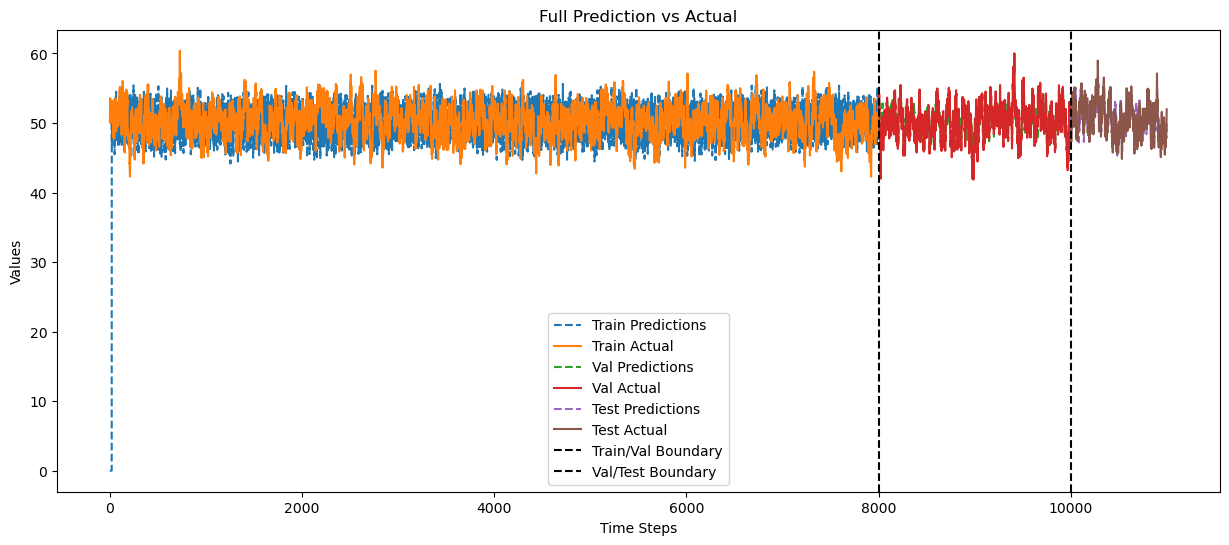

In [44]:
plot_full(1)

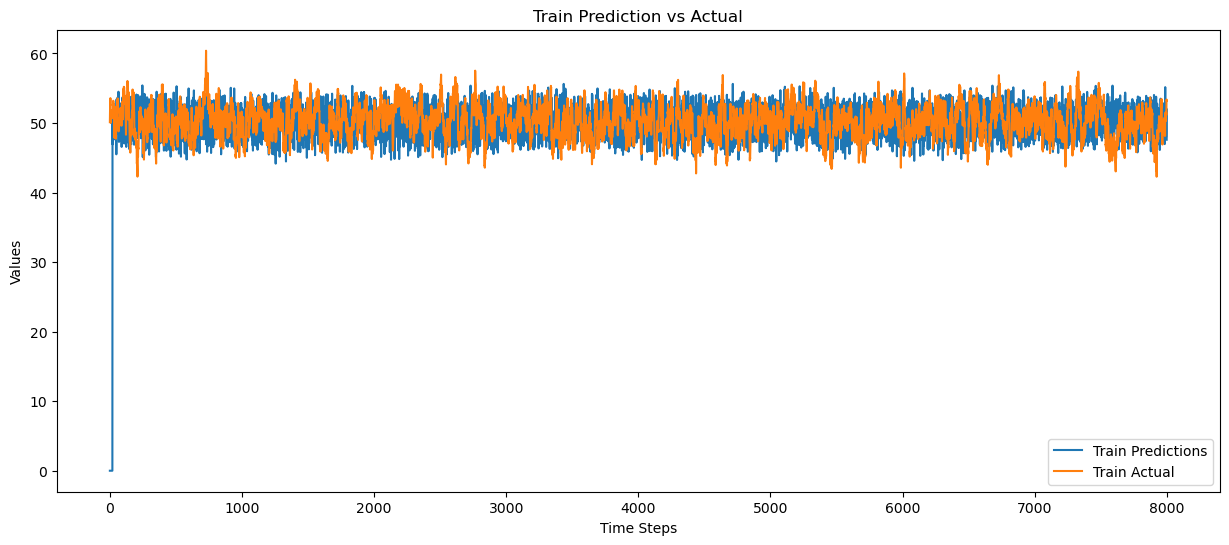

In [45]:
plot_train(1)

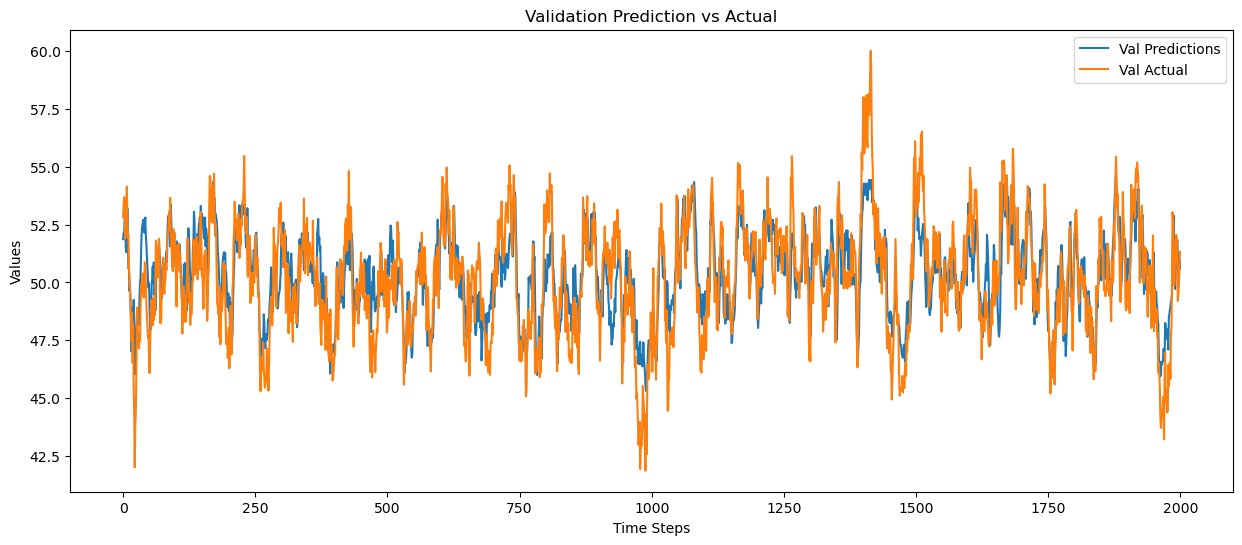

In [46]:
plot_val(1)

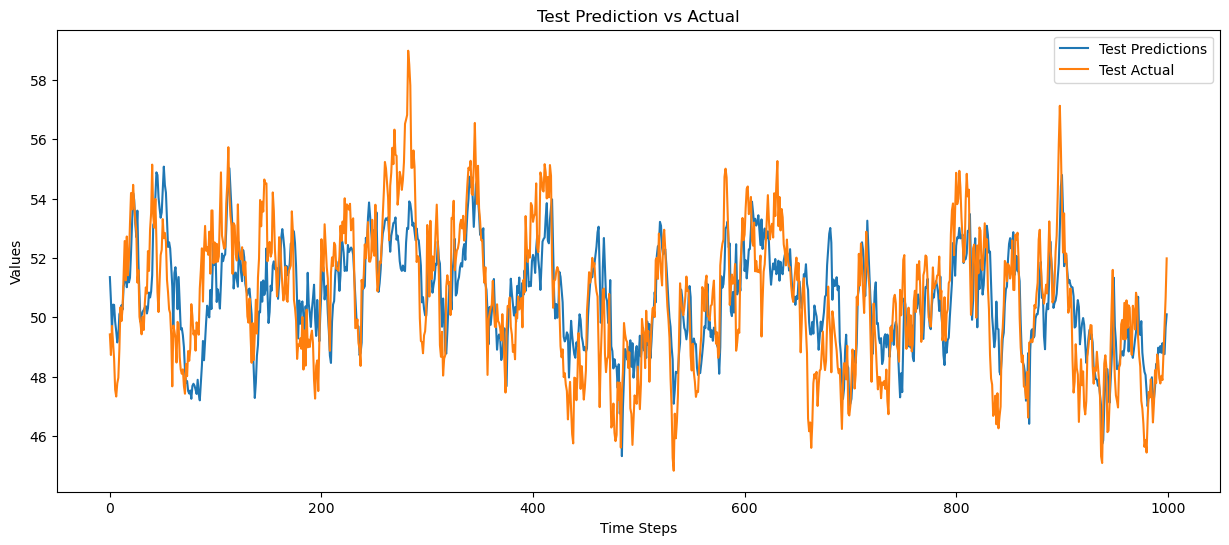

In [47]:
plot_test(1)

In [48]:
def plot_range(start, end, i):
    # 检查输入范围是否合法
    total_length = T_train + T_val + T_test
    if start < 0 or end > total_length or start >= end:
        raise ValueError(f"Invalid range: start={start}, end={end}. Check the range values.")

    # 拼接训练、验证和测试集的预测结果
    full_data = torch.cat([train_predictions.detach(), val_predictions.detach(), test_predictions.detach()], dim=0).cpu().numpy()
    full_actual = np.concatenate([data_manage.train_data_np, data_manage.val_data_np, data_manage.test_data_np], axis=1)

    # 检查节点索引 i 是否合法
    if i < 0 or i >= full_actual.shape[0]:
        raise ValueError(f"Invalid node index: i={i}. Check the node index.")

    plt.figure(figsize=(15, 6))

    # 在指定范围内绘制第 i 个节点的预测值与实际值
    plt.plot(range(start, end), full_data[start:end, i], label='Predictions')
    plt.plot(range(start, end), full_actual[i, start:end], label='Actual')

    # # 标记训练集和验证集的边界
    # if start <= T_train < end:
    #     plt.axvline(x=T_train, color='black', linestyle='--', label='Train/Val Boundary')
    # if start <= T_train + T_val < end:
    #     plt.axvline(x=T_train + T_val, color='black', linestyle='--', label='Val/Test Boundary')

    plt.legend()
    plt.title(f'Prediction vs Actual for Node {i} from {start} to {end}')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.show()


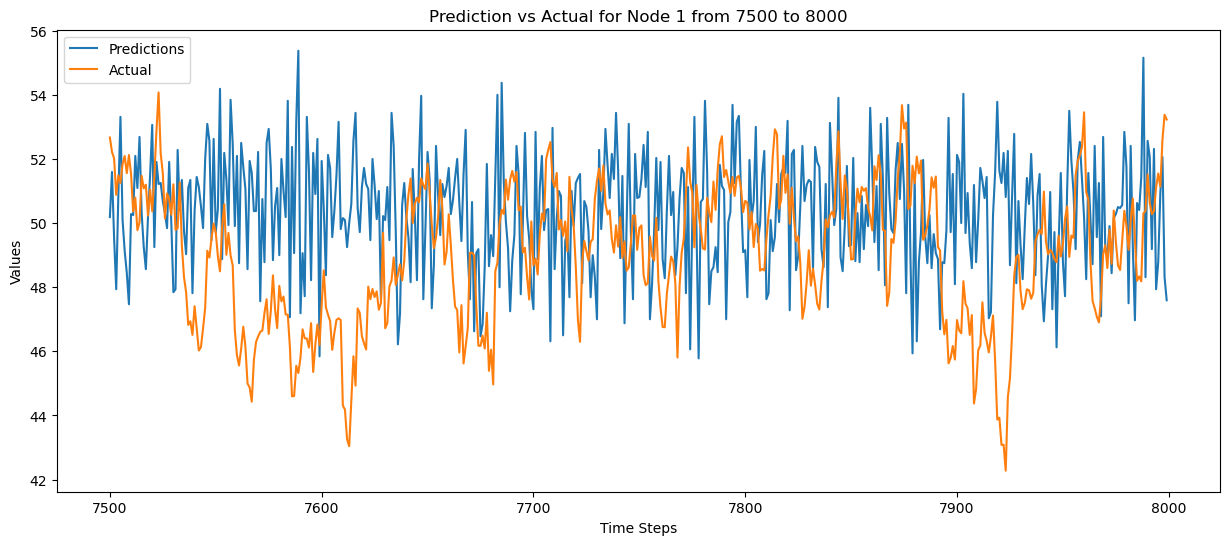

In [49]:
plot_range(7500, 8000, 1)

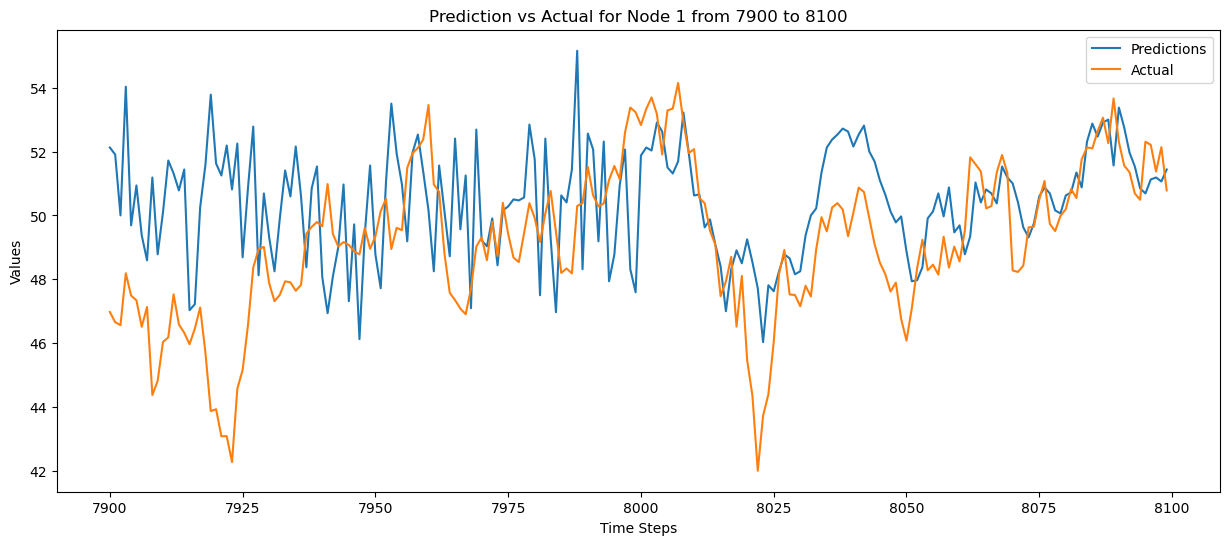

In [50]:
plot_range(7900, 8100, 1)

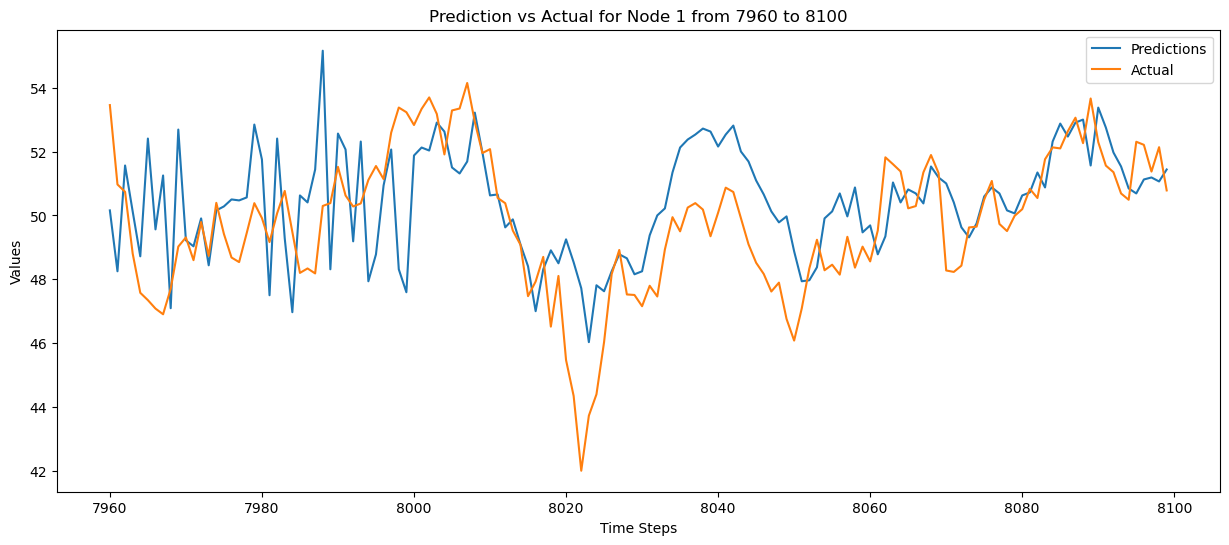

In [51]:
plot_range(7960, 8100, 1)

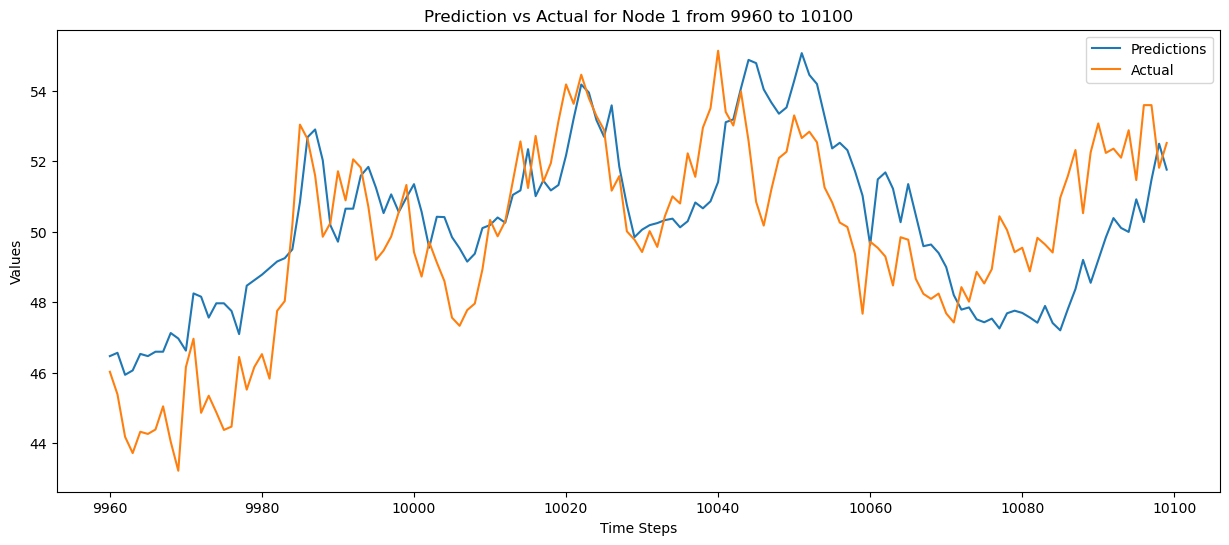

In [52]:
plot_range(9960, 10100, 1)

In [53]:
import numpy as np

# 假设 train_losses 和 val_losses 的长度已经定义
train_steps = len(train_losses)
val_steps = len(val_losses)

# 获取 epoch 的数量（即 train_with_val_learning_rates 的长度）
num_epochs = len(train_with_val_learning_rates)

# 计算每个学习率应重复的次数
train_repeats_per_epoch = train_steps // num_epochs
val_repeats_per_epoch = val_steps // num_epochs

# 扩展学习率列表用于 train_losses
train_extended_lr = np.repeat(train_with_val_learning_rates, train_repeats_per_epoch)

# 处理余数部分（不均等分的情况）
train_remaining_steps = train_steps - len(train_extended_lr)
if train_remaining_steps > 0:
    train_extended_lr = np.append(train_extended_lr, [train_with_val_learning_rates[-1]] * train_remaining_steps)

# 扩展学习率列表用于 val_losses
val_extended_lr = np.repeat(train_with_val_learning_rates, val_repeats_per_epoch)

# 处理余数部分（不均等分的情况）
val_remaining_steps = val_steps - len(val_extended_lr)
if val_remaining_steps > 0:
    val_extended_lr = np.append(val_extended_lr, [train_with_val_learning_rates[-1]] * val_remaining_steps)

# 现在，train_extended_lr 的长度应该与 train_losses 相同，val_extended_lr 的长度应该与 val_losses 相同


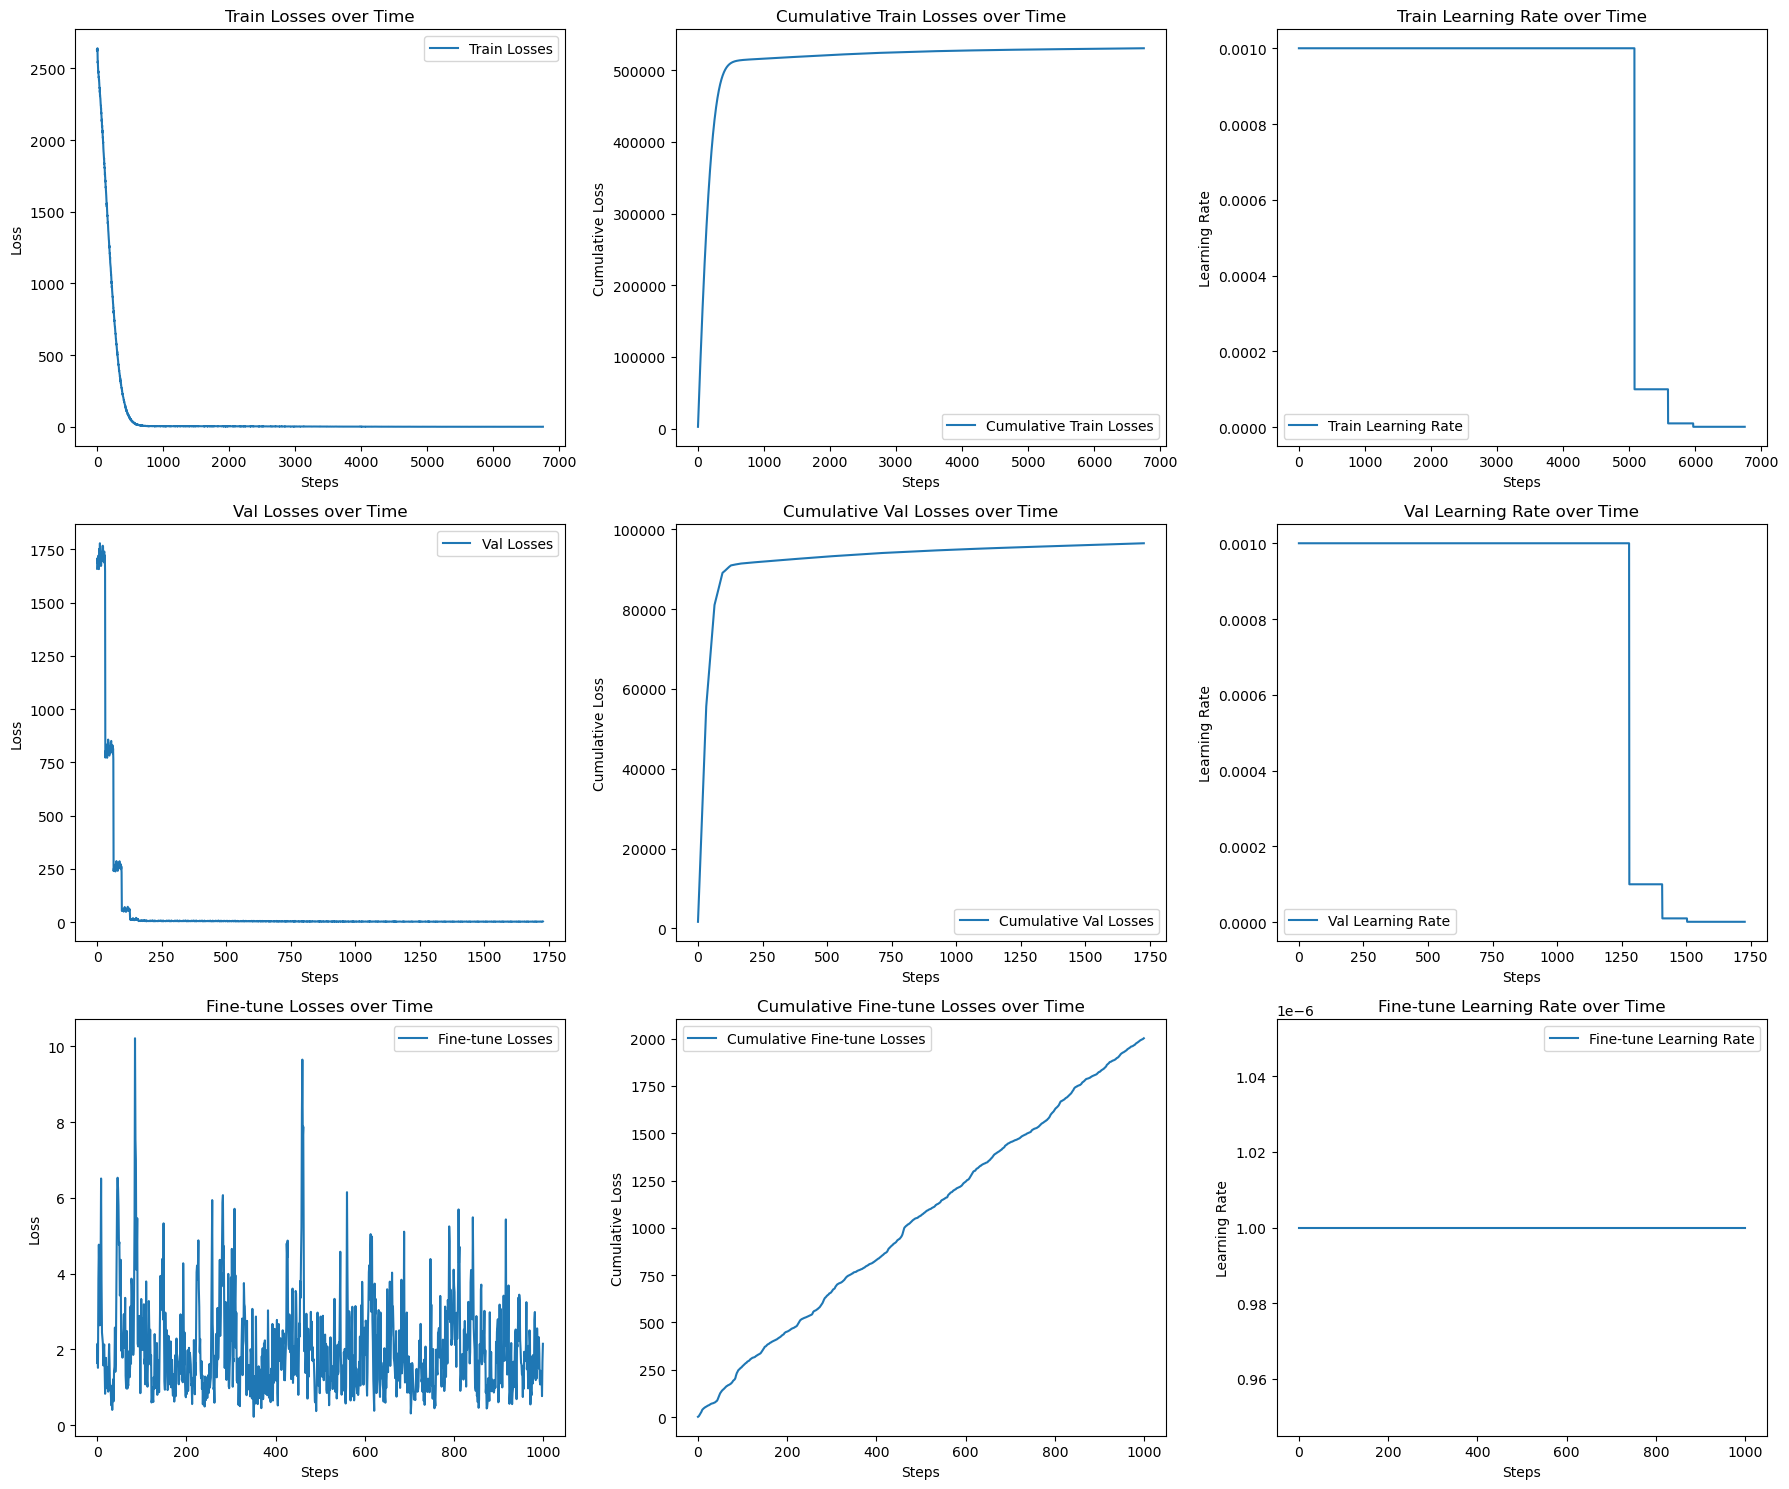

In [54]:
def plot_all_losses_and_lr(train_losses, val_losses, fine_tune_losses, train_extended_lr, val_extended_lr, fine_tune_learning_rates):
    fig, axs = plt.subplots(3, 3, figsize=(18, 15))

    # 训练集的单次损失、累积损失和学习率
    axs[0, 0].plot(train_losses, label='Train Losses')
    axs[0, 0].set_title('Train Losses over Time')
    axs[0, 0].set_xlabel('Steps')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    cumulative_train_losses = np.cumsum(train_losses)
    axs[0, 1].plot(cumulative_train_losses, label='Cumulative Train Losses')
    axs[0, 1].set_title('Cumulative Train Losses over Time')
    axs[0, 1].set_xlabel('Steps')
    axs[0, 1].set_ylabel('Cumulative Loss')
    axs[0, 1].legend()

    axs[0, 2].plot(train_extended_lr, label='Train Learning Rate')
    axs[0, 2].set_title('Train Learning Rate over Time')
    axs[0, 2].set_xlabel('Steps')
    axs[0, 2].set_ylabel('Learning Rate')
    axs[0, 2].legend()

    # 验证集的单次损失、累积损失和学习率
    axs[1, 0].plot(val_losses, label='Val Losses')
    axs[1, 0].set_title('Val Losses over Time')
    axs[1, 0].set_xlabel('Steps')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].legend()

    cumulative_val_losses = np.cumsum(val_losses)
    axs[1, 1].plot(cumulative_val_losses, label='Cumulative Val Losses')
    axs[1, 1].set_title('Cumulative Val Losses over Time')
    axs[1, 1].set_xlabel('Steps')
    axs[1, 1].set_ylabel('Cumulative Loss')
    axs[1, 1].legend()

    axs[1, 2].plot(val_extended_lr, label='Val Learning Rate')
    axs[1, 2].set_title('Val Learning Rate over Time')
    axs[1, 2].set_xlabel('Steps')
    axs[1, 2].set_ylabel('Learning Rate')
    axs[1, 2].legend()

    # 微调测试集的单次损失、累积损失和学习率
    axs[2, 0].plot(fine_tune_losses, label='Fine-tune Losses')
    axs[2, 0].set_title('Fine-tune Losses over Time')
    axs[2, 0].set_xlabel('Steps')
    axs[2, 0].set_ylabel('Loss')
    axs[2, 0].legend()

    cumulative_fine_tune_losses = np.cumsum(fine_tune_losses)
    axs[2, 1].plot(cumulative_fine_tune_losses, label='Cumulative Fine-tune Losses')
    axs[2, 1].set_title('Cumulative Fine-tune Losses over Time')
    axs[2, 1].set_xlabel('Steps')
    axs[2, 1].set_ylabel('Cumulative Loss')
    axs[2, 1].legend()

    axs[2, 2].plot(fine_tune_learning_rates, label='Fine-tune Learning Rate')
    axs[2, 2].set_title('Fine-tune Learning Rate over Time')
    axs[2, 2].set_xlabel('Steps')
    axs[2, 2].set_ylabel('Learning Rate')
    axs[2, 2].legend()

    plt.tight_layout()
    plt.show()

# 调用函数
plot_all_losses_and_lr(train_losses, val_losses, fine_tune_losses, train_extended_lr, val_extended_lr, fine_tune_learning_rates)


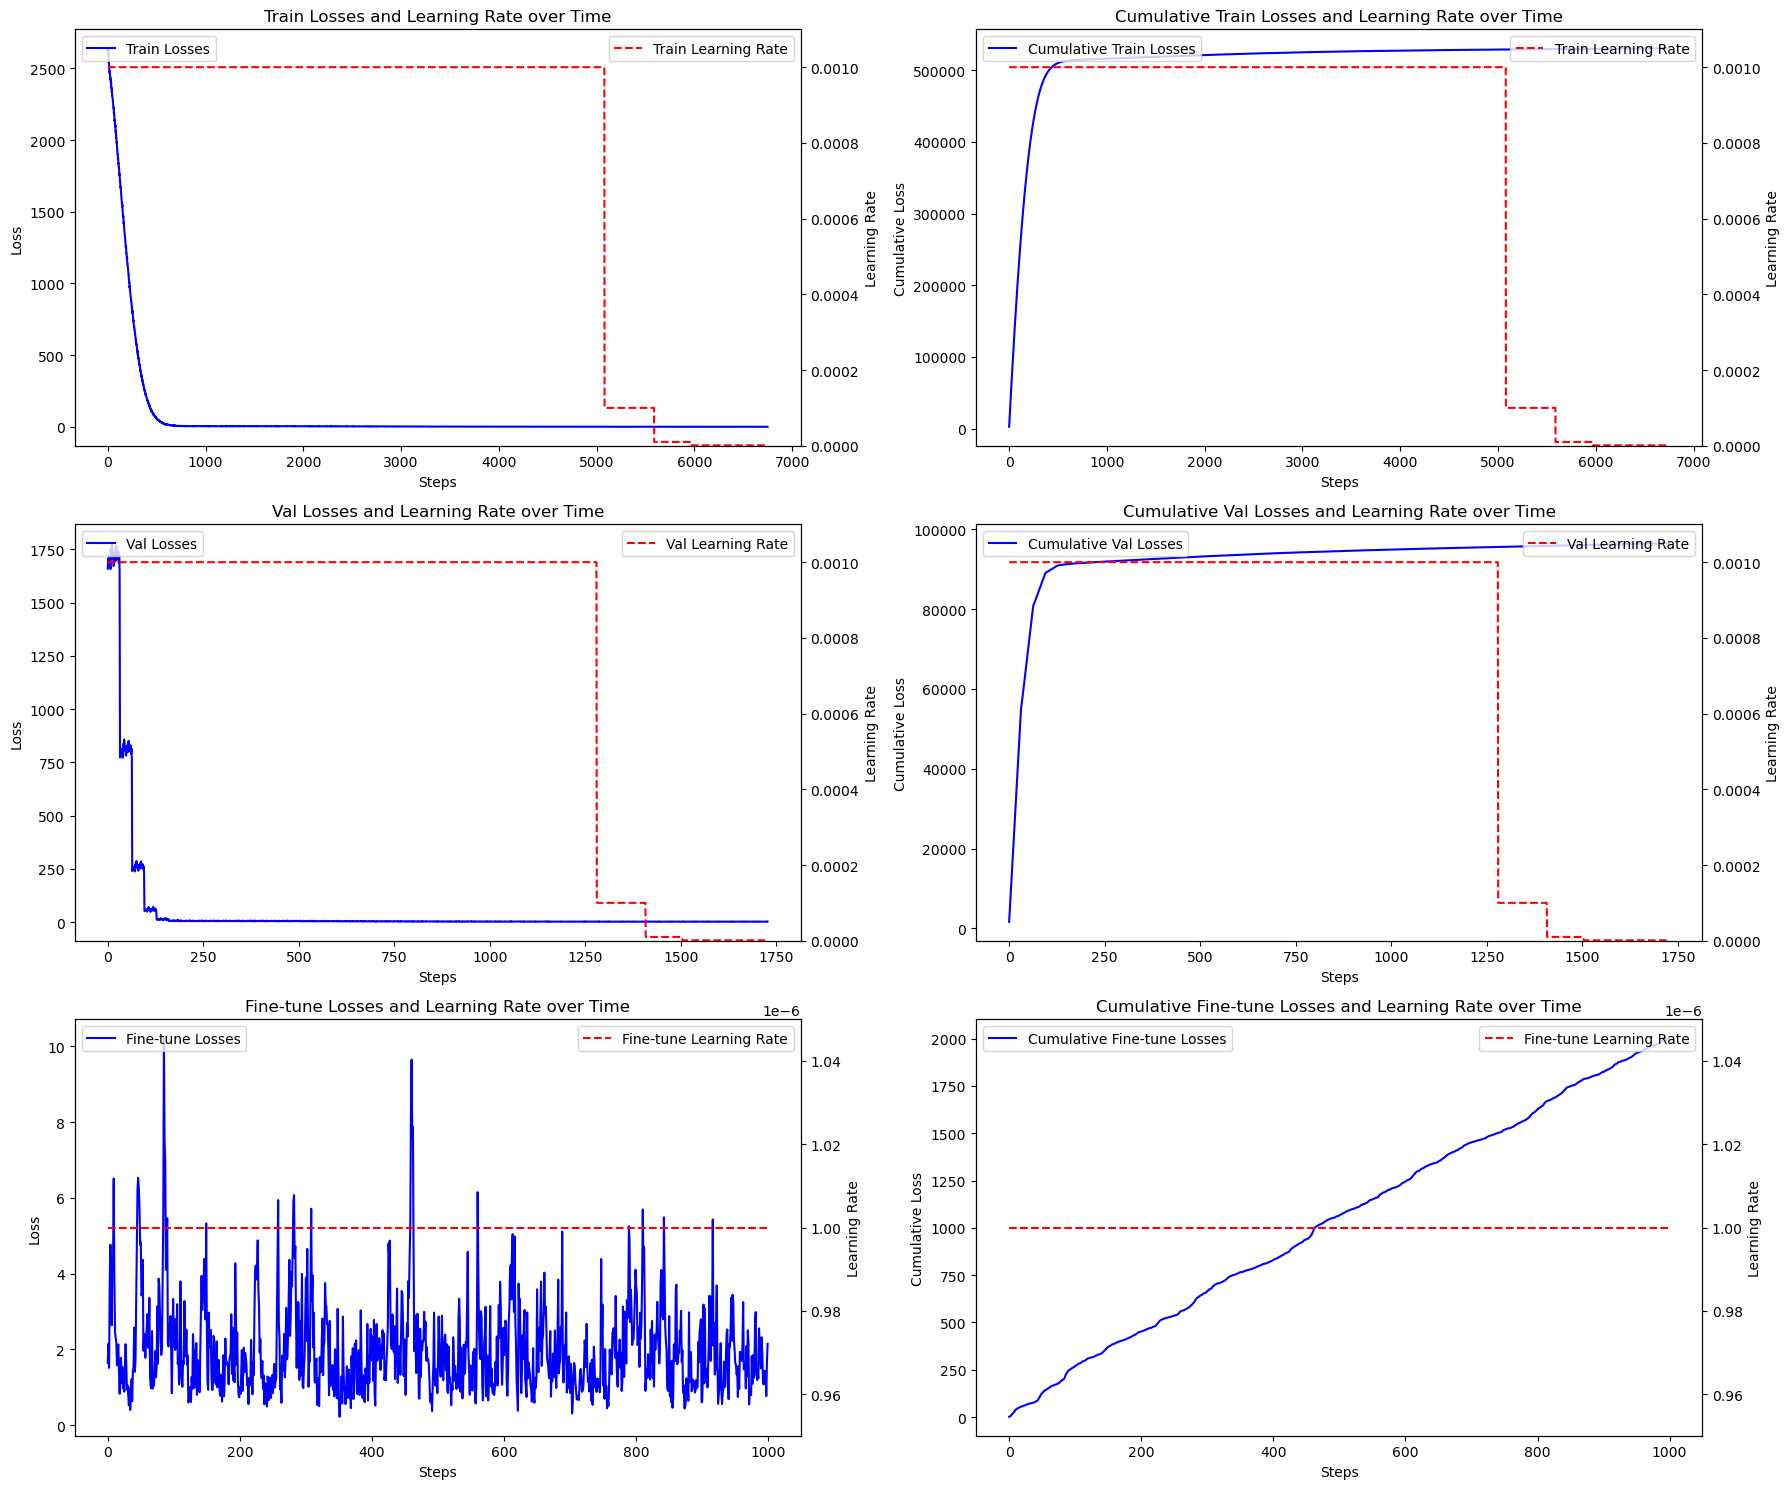

In [55]:
def plot_all_losses_and_lr(train_losses, val_losses, fine_tune_losses, train_extended_lr, val_extended_lr, fine_tune_learning_rates):
    fig, axs = plt.subplots(3, 2, figsize=(18, 15))  # 2列布局

    # 训练集的单次损失和学习率
    ax1 = axs[0, 0]
    ax2 = ax1.twinx()
    ax1.plot(train_losses, label='Train Losses', color='blue')
    ax2.plot(train_extended_lr, label='Train Learning Rate', color='red', linestyle='--')
    ax1.set_title('Train Losses and Learning Rate over Time')
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Learning Rate')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax2.set_ylim([0, max(train_extended_lr) * 1.1])  # 调整学习率Y轴范围

    # 训练集的累积损失和学习率
    ax3 = axs[0, 1]
    ax4 = ax3.twinx()
    cumulative_train_losses = np.cumsum(train_losses)
    ax3.plot(cumulative_train_losses, label='Cumulative Train Losses', color='blue')
    ax4.plot(train_extended_lr, label='Train Learning Rate', color='red', linestyle='--')
    ax3.set_title('Cumulative Train Losses and Learning Rate over Time')
    ax3.set_xlabel('Steps')
    ax3.set_ylabel('Cumulative Loss')
    ax4.set_ylabel('Learning Rate')
    ax3.legend(loc='upper left')
    ax4.legend(loc='upper right')
    ax4.set_ylim([0, max(train_extended_lr) * 1.1])  # 调整学习率Y轴范围

    # 验证集的单次损失和学习率
    ax5 = axs[1, 0]
    ax6 = ax5.twinx()
    ax5.plot(val_losses, label='Val Losses', color='blue')
    ax6.plot(val_extended_lr, label='Val Learning Rate', color='red', linestyle='--')
    ax5.set_title('Val Losses and Learning Rate over Time')
    ax5.set_xlabel('Steps')
    ax5.set_ylabel('Loss')
    ax6.set_ylabel('Learning Rate')
    ax5.legend(loc='upper left')
    ax6.legend(loc='upper right')
    ax6.set_ylim([0, max(val_extended_lr) * 1.1])  # 调整学习率Y轴范围

    # 验证集的累积损失和学习率
    ax7 = axs[1, 1]
    ax8 = ax7.twinx()
    cumulative_val_losses = np.cumsum(val_losses)
    ax7.plot(cumulative_val_losses, label='Cumulative Val Losses', color='blue')
    ax8.plot(val_extended_lr, label='Val Learning Rate', color='red', linestyle='--')
    ax7.set_title('Cumulative Val Losses and Learning Rate over Time')
    ax7.set_xlabel('Steps')
    ax7.set_ylabel('Cumulative Loss')
    ax8.set_ylabel('Learning Rate')
    ax7.legend(loc='upper left')
    ax8.legend(loc='upper right')
    ax8.set_ylim([0, max(val_extended_lr) * 1.1])  # 调整学习率Y轴范围

    # 微调阶段的单次损失和学习率
    ax9 = axs[2, 0]
    ax10 = ax9.twinx()
    ax9.plot(fine_tune_losses, label='Fine-tune Losses', color='blue')
    ax10.plot(fine_tune_learning_rates, label='Fine-tune Learning Rate', color='red', linestyle='--')
    ax9.set_title('Fine-tune Losses and Learning Rate over Time')
    ax9.set_xlabel('Steps')
    ax9.set_ylabel('Loss')
    ax10.set_ylabel('Learning Rate')
    ax9.legend(loc='upper left')
    ax10.legend(loc='upper right')
    ax10.set_ylim([min(fine_tune_learning_rates) * 0.95, max(fine_tune_learning_rates) * 1.05])  # 调整学习率Y轴范围

    # 微调阶段的累积损失和学习率
    ax11 = axs[2, 1]
    ax12 = ax11.twinx()
    cumulative_fine_tune_losses = np.cumsum(fine_tune_losses)
    ax11.plot(cumulative_fine_tune_losses, label='Cumulative Fine-tune Losses', color='blue')
    ax12.plot(fine_tune_learning_rates, label='Fine-tune Learning Rate', color='red', linestyle='--')
    ax11.set_title('Cumulative Fine-tune Losses and Learning Rate over Time')
    ax11.set_xlabel('Steps')
    ax11.set_ylabel('Cumulative Loss')
    ax12.set_ylabel('Learning Rate')
    ax11.legend(loc='upper left')
    ax12.legend(loc='upper right')
    ax12.set_ylim([min(fine_tune_learning_rates) * 0.95, max(fine_tune_learning_rates) * 1.05])  # 调整学习率Y轴范围

    plt.tight_layout()
    plt.show()

# 调用函数
plot_all_losses_and_lr(train_losses, val_losses, fine_tune_losses, train_extended_lr, val_extended_lr, fine_tune_learning_rates)


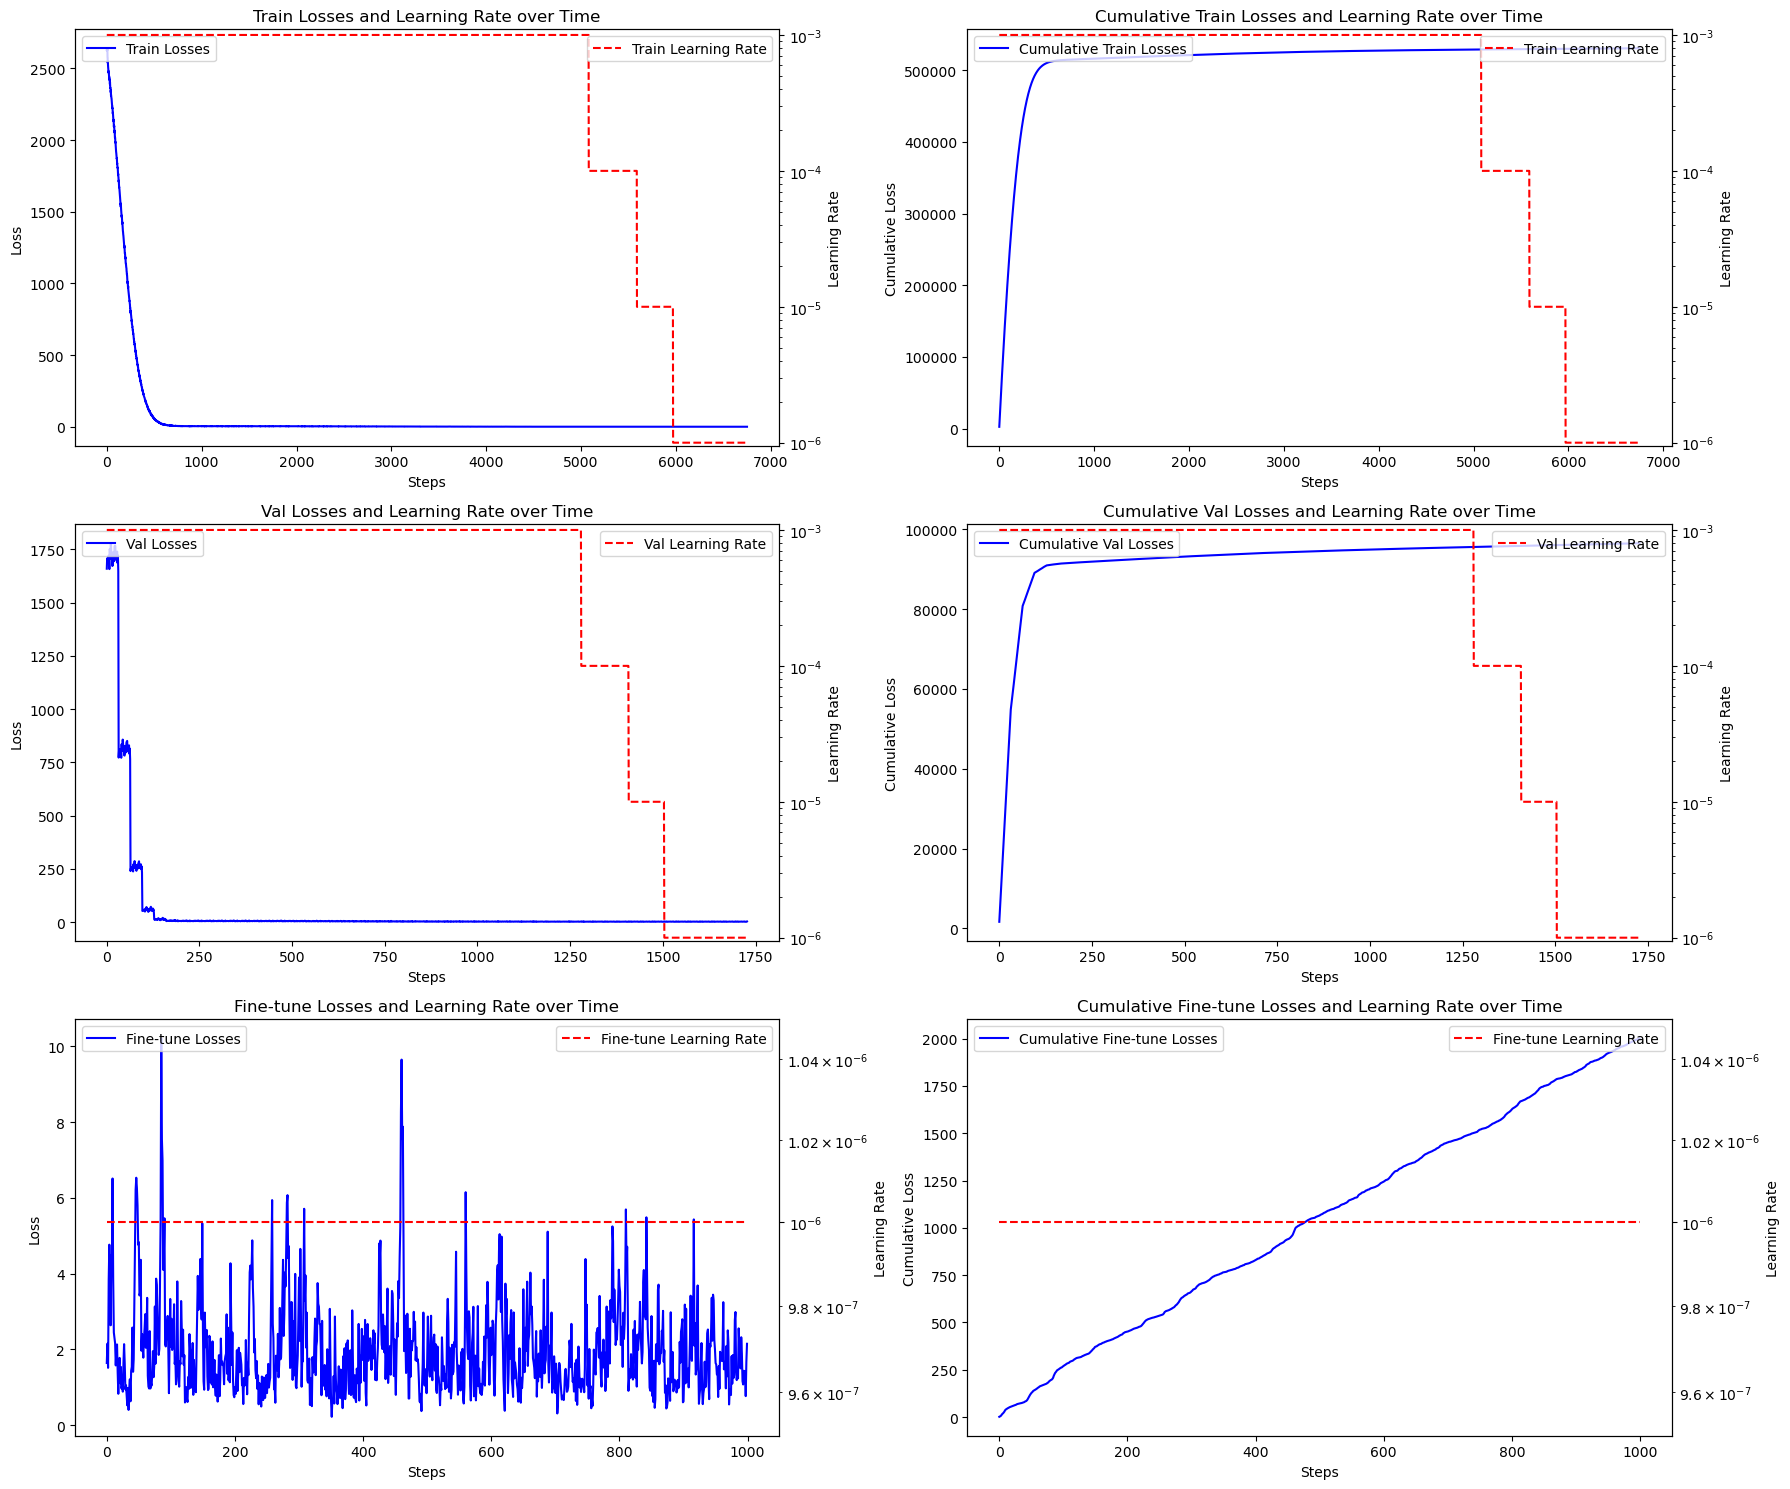

In [56]:
def plot_all_losses_and_lr(train_losses, val_losses, fine_tune_losses, train_extended_lr, val_extended_lr, fine_tune_learning_rates):
    fig, axs = plt.subplots(3, 2, figsize=(18, 15))  # 2列布局

    # 训练集的单次损失和学习率
    ax1 = axs[0, 0]
    ax2 = ax1.twinx()
    ax1.plot(train_losses, label='Train Losses', color='blue')
    ax2.plot(train_extended_lr, label='Train Learning Rate', color='red', linestyle='--')
    ax1.set_title('Train Losses and Learning Rate over Time')
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Learning Rate')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax2.set_yscale('log')  # 设置为对数尺度
    ax2.set_ylim([min(train_extended_lr) * 0.95, max(train_extended_lr) * 1.1])  # 调整学习率Y轴范围

    # 训练集的累积损失和学习率
    ax3 = axs[0, 1]
    ax4 = ax3.twinx()
    cumulative_train_losses = np.cumsum(train_losses)
    ax3.plot(cumulative_train_losses, label='Cumulative Train Losses', color='blue')
    ax4.plot(train_extended_lr, label='Train Learning Rate', color='red', linestyle='--')
    ax3.set_title('Cumulative Train Losses and Learning Rate over Time')
    ax3.set_xlabel('Steps')
    ax3.set_ylabel('Cumulative Loss')
    ax4.set_ylabel('Learning Rate')
    ax3.legend(loc='upper left')
    ax4.legend(loc='upper right')
    ax4.set_yscale('log')  # 设置为对数尺度
    ax4.set_ylim([min(train_extended_lr) * 0.95, max(train_extended_lr) * 1.1])  # 调整学习率Y轴范围

    # 验证集的单次损失和学习率
    ax5 = axs[1, 0]
    ax6 = ax5.twinx()
    ax5.plot(val_losses, label='Val Losses', color='blue')
    ax6.plot(val_extended_lr, label='Val Learning Rate', color='red', linestyle='--')
    ax5.set_title('Val Losses and Learning Rate over Time')
    ax5.set_xlabel('Steps')
    ax5.set_ylabel('Loss')
    ax6.set_ylabel('Learning Rate')
    ax5.legend(loc='upper left')
    ax6.legend(loc='upper right')
    ax6.set_yscale('log')  # 设置为对数尺度
    ax6.set_ylim([min(val_extended_lr) * 0.95, max(val_extended_lr) * 1.1])  # 调整学习率Y轴范围

    # 验证集的累积损失和学习率
    ax7 = axs[1, 1]
    ax8 = ax7.twinx()
    cumulative_val_losses = np.cumsum(val_losses)
    ax7.plot(cumulative_val_losses, label='Cumulative Val Losses', color='blue')
    ax8.plot(val_extended_lr, label='Val Learning Rate', color='red', linestyle='--')
    ax7.set_title('Cumulative Val Losses and Learning Rate over Time')
    ax7.set_xlabel('Steps')
    ax7.set_ylabel('Cumulative Loss')
    ax8.set_ylabel('Learning Rate')
    ax7.legend(loc='upper left')
    ax8.legend(loc='upper right')
    ax8.set_yscale('log')  # 设置为对数尺度
    ax8.set_ylim([min(val_extended_lr) * 0.95, max(val_extended_lr) * 1.1])  # 调整学习率Y轴范围

    # 微调阶段的单次损失和学习率
    ax9 = axs[2, 0]
    ax10 = ax9.twinx()
    ax9.plot(fine_tune_losses, label='Fine-tune Losses', color='blue')
    ax10.plot(fine_tune_learning_rates, label='Fine-tune Learning Rate', color='red', linestyle='--')
    ax9.set_title('Fine-tune Losses and Learning Rate over Time')
    ax9.set_xlabel('Steps')
    ax9.set_ylabel('Loss')
    ax10.set_ylabel('Learning Rate')
    ax9.legend(loc='upper left')
    ax10.legend(loc='upper right')
    ax10.set_yscale('log')  # 设置为对数尺度
    ax10.set_ylim([min(fine_tune_learning_rates) * 0.95, max(fine_tune_learning_rates) * 1.05])  # 调整学习率Y轴范围

    # 微调阶段的累积损失和学习率
    ax11 = axs[2, 1]
    ax12 = ax11.twinx()
    cumulative_fine_tune_losses = np.cumsum(fine_tune_losses)
    ax11.plot(cumulative_fine_tune_losses, label='Cumulative Fine-tune Losses', color='blue')
    ax12.plot(fine_tune_learning_rates, label='Fine-tune Learning Rate', color='red', linestyle='--')
    ax11.set_title('Cumulative Fine-tune Losses and Learning Rate over Time')
    ax11.set_xlabel('Steps')
    ax11.set_ylabel('Cumulative Loss')
    ax12.set_ylabel('Learning Rate')
    ax11.legend(loc='upper left')
    ax12.legend(loc='upper right')
    ax12.set_yscale('log')  # 设置为对数尺度
    ax12.set_ylim([min(fine_tune_learning_rates) * 0.95, max(fine_tune_learning_rates) * 1.05])  # 调整学习率Y轴范围

    plt.tight_layout()
    plt.show()

# 调用函数
plot_all_losses_and_lr(train_losses, val_losses, fine_tune_losses, train_extended_lr, val_extended_lr, fine_tune_learning_rates)


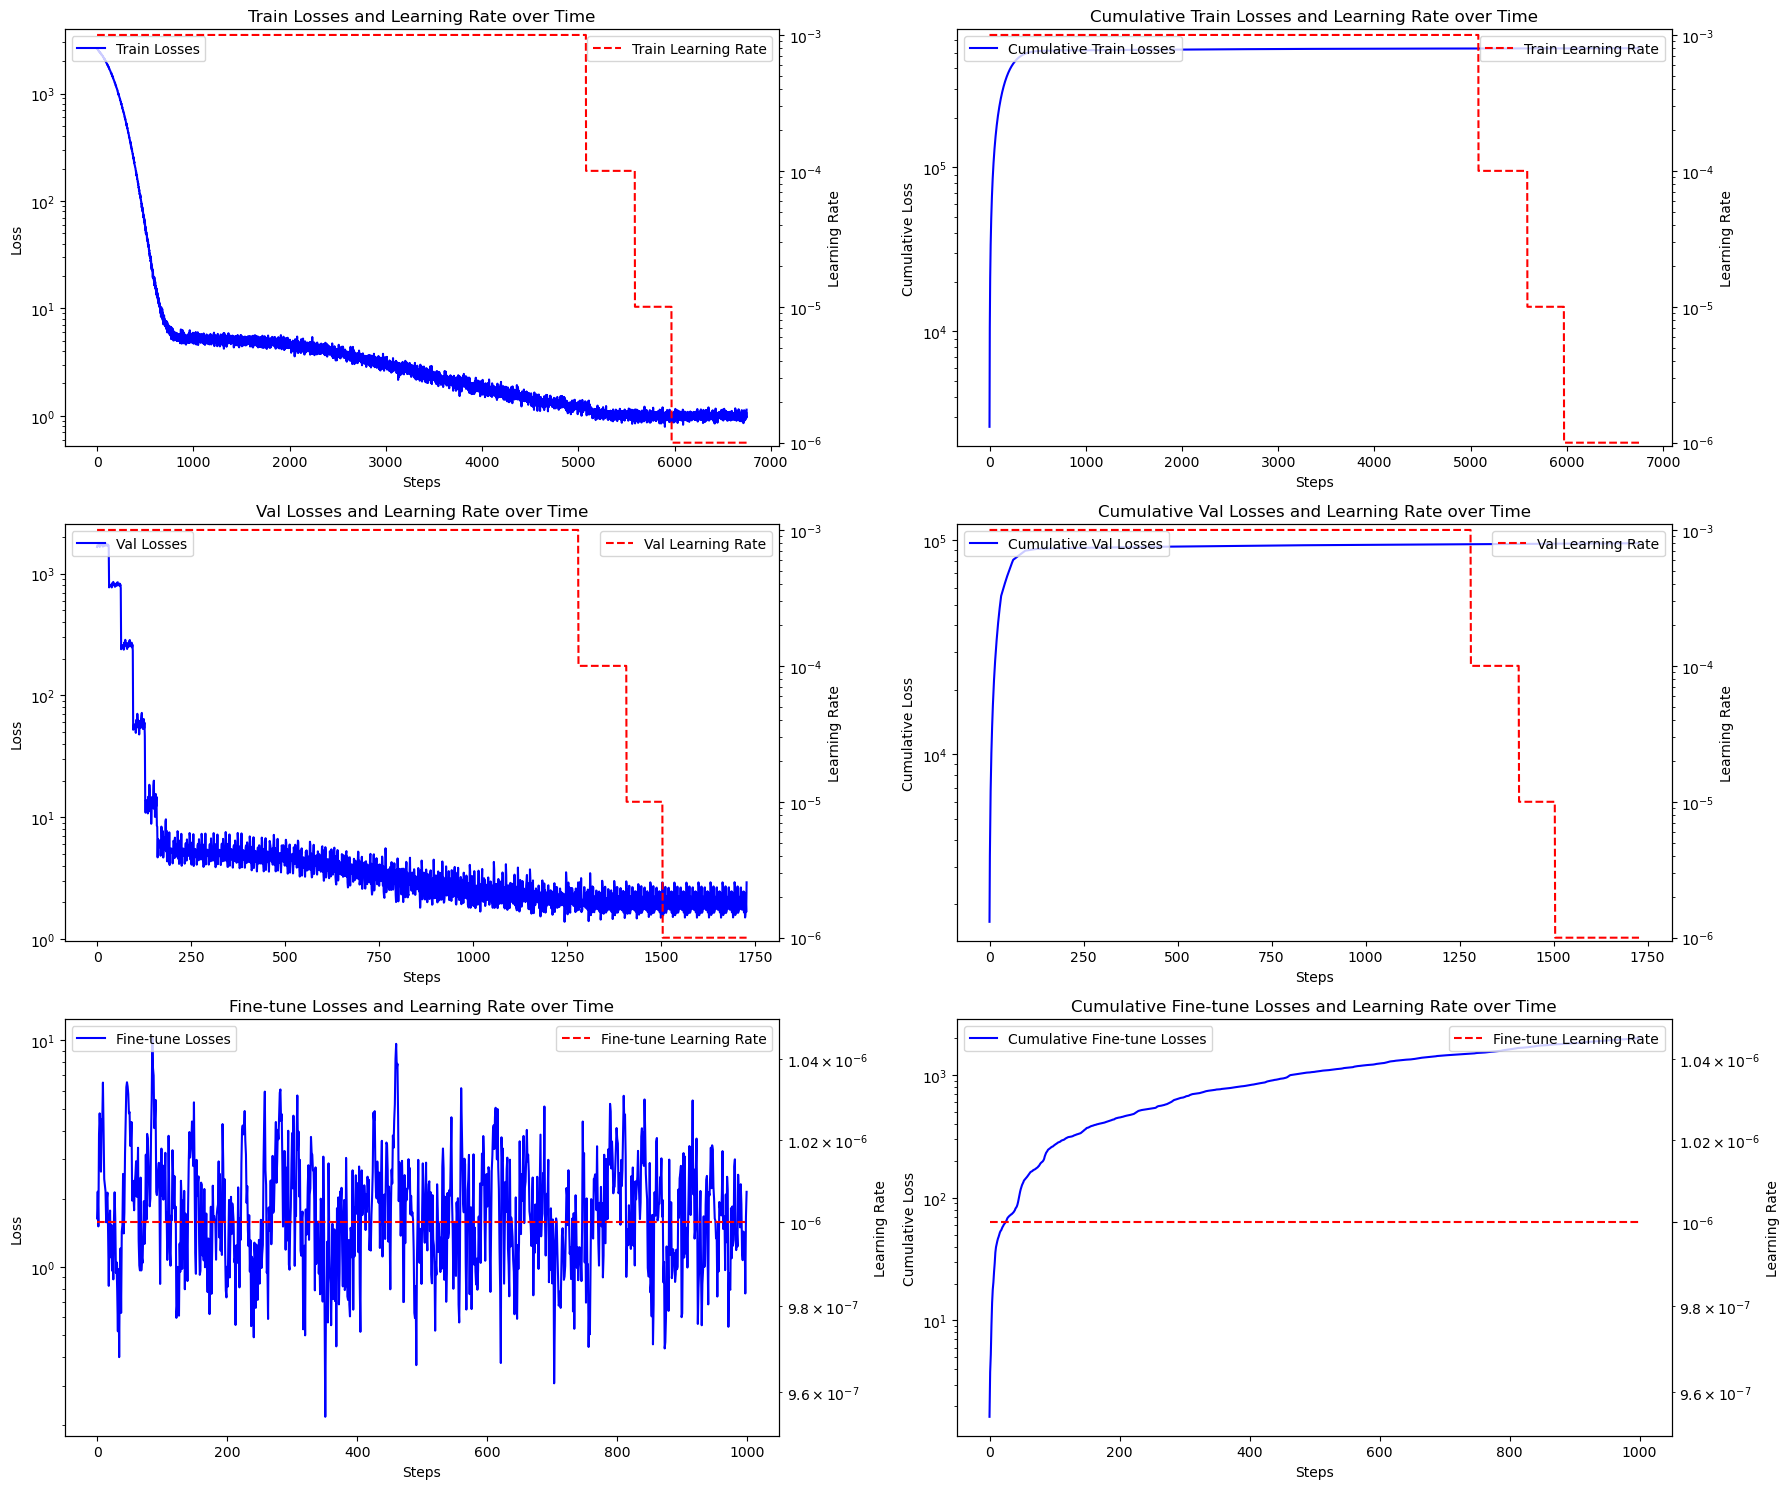

In [57]:
def plot_all_losses_and_lr(train_losses, val_losses, fine_tune_losses, train_extended_lr, val_extended_lr, fine_tune_learning_rates):
    fig, axs = plt.subplots(3, 2, figsize=(18, 15))  # 2列布局

    # 训练集的单次损失和学习率
    ax1 = axs[0, 0]
    ax2 = ax1.twinx()
    ax1.plot(train_losses, label='Train Losses', color='blue')
    ax2.plot(train_extended_lr, label='Train Learning Rate', color='red', linestyle='--')
    ax1.set_title('Train Losses and Learning Rate over Time')
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Learning Rate')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.set_yscale('log')  # 左侧轴设置为对数尺度
    ax2.set_yscale('log')  # 右侧轴设置为对数尺度
    ax2.set_ylim([min(train_extended_lr) * 0.95, max(train_extended_lr) * 1.1])

    # 训练集的累积损失和学习率
    ax3 = axs[0, 1]
    ax4 = ax3.twinx()
    cumulative_train_losses = np.cumsum(train_losses)
    ax3.plot(cumulative_train_losses, label='Cumulative Train Losses', color='blue')
    ax4.plot(train_extended_lr, label='Train Learning Rate', color='red', linestyle='--')
    ax3.set_title('Cumulative Train Losses and Learning Rate over Time')
    ax3.set_xlabel('Steps')
    ax3.set_ylabel('Cumulative Loss')
    ax4.set_ylabel('Learning Rate')
    ax3.legend(loc='upper left')
    ax4.legend(loc='upper right')
    ax3.set_yscale('log')  # 左侧轴设置为对数尺度
    ax4.set_yscale('log')  # 右侧轴设置为对数尺度
    ax4.set_ylim([min(train_extended_lr) * 0.95, max(train_extended_lr) * 1.1])

    # 验证集的单次损失和学习率
    ax5 = axs[1, 0]
    ax6 = ax5.twinx()
    ax5.plot(val_losses, label='Val Losses', color='blue')
    ax6.plot(val_extended_lr, label='Val Learning Rate', color='red', linestyle='--')
    ax5.set_title('Val Losses and Learning Rate over Time')
    ax5.set_xlabel('Steps')
    ax5.set_ylabel('Loss')
    ax6.set_ylabel('Learning Rate')
    ax5.legend(loc='upper left')
    ax6.legend(loc='upper right')
    ax5.set_yscale('log')  # 左侧轴设置为对数尺度
    ax6.set_yscale('log')  # 右侧轴设置为对数尺度
    ax6.set_ylim([min(val_extended_lr) * 0.95, max(val_extended_lr) * 1.1])

    # 验证集的累积损失和学习率
    ax7 = axs[1, 1]
    ax8 = ax7.twinx()
    cumulative_val_losses = np.cumsum(val_losses)
    ax7.plot(cumulative_val_losses, label='Cumulative Val Losses', color='blue')
    ax8.plot(val_extended_lr, label='Val Learning Rate', color='red', linestyle='--')
    ax7.set_title('Cumulative Val Losses and Learning Rate over Time')
    ax7.set_xlabel('Steps')
    ax7.set_ylabel('Cumulative Loss')
    ax8.set_ylabel('Learning Rate')
    ax7.legend(loc='upper left')
    ax8.legend(loc='upper right')
    ax7.set_yscale('log')  # 左侧轴设置为对数尺度
    ax8.set_yscale('log')  # 右侧轴设置为对数尺度
    ax8.set_ylim([min(val_extended_lr) * 0.95, max(val_extended_lr) * 1.1])

    # 微调阶段的单次损失和学习率
    ax9 = axs[2, 0]
    ax10 = ax9.twinx()
    ax9.plot(fine_tune_losses, label='Fine-tune Losses', color='blue')
    ax10.plot(fine_tune_learning_rates, label='Fine-tune Learning Rate', color='red', linestyle='--')
    ax9.set_title('Fine-tune Losses and Learning Rate over Time')
    ax9.set_xlabel('Steps')
    ax9.set_ylabel('Loss')
    ax10.set_ylabel('Learning Rate')
    ax9.legend(loc='upper left')
    ax10.legend(loc='upper right')
    ax9.set_yscale('log')  # 左侧轴设置为对数尺度
    ax10.set_yscale('log')  # 右侧轴设置为对数尺度
    ax10.set_ylim([min(fine_tune_learning_rates) * 0.95, max(fine_tune_learning_rates) * 1.05])

    # 微调阶段的累积损失和学习率
    ax11 = axs[2, 1]
    ax12 = ax11.twinx()
    cumulative_fine_tune_losses = np.cumsum(fine_tune_losses)
    ax11.plot(cumulative_fine_tune_losses, label='Cumulative Fine-tune Losses', color='blue')
    ax12.plot(fine_tune_learning_rates, label='Fine-tune Learning Rate', color='red', linestyle='--')
    ax11.set_title('Cumulative Fine-tune Losses and Learning Rate over Time')
    ax11.set_xlabel('Steps')
    ax11.set_ylabel('Cumulative Loss')
    ax12.set_ylabel('Learning Rate')
    ax11.legend(loc='upper left')
    ax12.legend(loc='upper right')
    ax11.set_yscale('log')  # 左侧轴设置为对数尺度
    ax12.set_yscale('log')  # 右侧轴设置为对数尺度
    ax12.set_ylim([min(fine_tune_learning_rates) * 0.95, max(fine_tune_learning_rates) * 1.05])

    plt.tight_layout()
    plt.show()

# 调用函数
plot_all_losses_and_lr(train_losses, val_losses, fine_tune_losses, train_extended_lr, val_extended_lr, fine_tune_learning_rates)
